## Read the data from RDS file

In [2]:
library(WGCNA)
library(reshape2)
library(stringr)
library(dplyr)
library(ggplot2)
library(tidyr)
# 
options(stringsAsFactors = FALSE)
# 打开多线程
enableWGCNAThreads()

## Allowing parallel execution with maximum threads


# Deseq2的varianceStabilizingTransformation

# exprMat <- './csv/reduced_assay_vst_shoot_3DMs_Mine_20220421.csv'

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths




Allowing parallel execution with up to 127 working processes.


In [3]:
dataExpr <- readRDS('./Rdata/new_for_WGCNA_vst.Rds') %>% as.data.frame 
# dataExpr

In [4]:
map_id_name <- read.csv('../gene_table_and_other_scripts/bioMartR_Ath_all_genes_info_googled.csv')
map_id_name <- map_id_name %>% dplyr::rename('gene_name' = 'external_gene_name', 'gene_id' = 'ensembl_gene_id')
sample_n(map_id_name, 2)

gene_id   gene_name  
1 AT1G30960 ERA-2      
2 AT2G39175 ath-MIR160a

In [5]:
map_id_name %>% filter(gene_name %>% str_detect('^\\d'))

gene_id   gene_name              
1  AT5G38120 4CL8                   
2  AT5G13050 5-FCL                  
3  AT3G21240 4CL2                   
4  AT2G26260 3BETAHSD/D2            
5  AT1G51680 4CL1                   
6  AT4G23800 3xHMG-box2             
7  AT1G65060 4CL3                   
8  AT1G47510 5PTASE11               
9  AT1G03410 2A6                    
10 AT2G43900 5PTase12               
11 AT5G06290 2-Cys Prx B            
12 AT3G21230 4CL5                   
13 AT4G11080 3xHMG-box1             
14 AT1G47290 3BETAHSD/D1            
15 AT2G31830 5PTase14               
16 AT1G05630 5PTASE13               
17 AT3G09570 7TM2                   
18 AT5G42090 7TM4                   
19 AT3G19480 3-PGDH                 
20 AT2G01070 7TM5                   
21 AT3G19010 2-OXOGLUTARATEOXYGENASE
22 AT3G11630 2CPA

In [6]:
source('../gene_table_and_other_scripts/theme_Publication.R')

Registering fonts with R

aakar already registered with pdfFont().

Abyssinica SIL already registered with pdfFont().

Andale Mono already registered with pdfFont().

Ani already registered with pdfFont().

AnjaliOldLipi already registered with pdfFont().

Arial already registered with pdfFont().

Arial Black already registered with pdfFont().

Chandas already registered with pdfFont().

Comic Sans MS already registered with pdfFont().

Courier New already registered with pdfFont().

DejaVu Sans already registered with pdfFont().

DejaVu Sans Mono already registered with pdfFont().

DejaVu Serif already registered with pdfFont().

Dhurjati already registered with pdfFont().

Droid Sans Fallback already registered with pdfFont().

Dyuthi already registered with pdfFont().

FreeMono already registered with pdfFont().

FreeSans already registered with pdfFont().

FreeSerif already registered with pdfFont().

Gargi already registered with pdfFont().

Garuda already registered with pdfFont(

In [7]:
Ath_TFs <- read.csv('../3DMs_pathogen/TFs/Ath_TF_list.txt', sep = '\t')

In [8]:
WGCNA_export_path <- './WGCNA_output_all_test'

create_directory_if_not_exists <- function(dir_path) {
  # Check if the directory exists; if not, create the directory
  if (!file.exists(dir_path)) {
    dir.create(dir_path, recursive = TRUE)
  }
}

create_directory_if_not_exists(WGCNA_export_path)

plots_path <- paste0(WGCNA_export_path, "/plots/")
create_directory_if_not_exists(plots_path)

In [9]:

type = "signed"

# cor
#  biweight mid-correlation & bicor
# corType: pearson or bicor

corType = "bicor"

corFnc = ifelse(corType=="pearson", cor, bicor)

maxPOutliers = ifelse(corType=="pearson",1,0.05)


robustY = ifelse(corType=="pearson",T,F)

In [10]:
head(dataExpr, 2)
dim(dataExpr)

DM1/DM2d_1 Col-0_12_1 DM1/DM2d_2 Col-0_12_2 DM1/DM2d_3 DM6/DM7_1
AT1G30814 8.027459   7.361037   8.231559   7.144435   8.074163   7.852032 
AT1G78930 8.464617   9.151971   8.156042   9.324082   8.359510   8.724277 
          Col-0_14_1 DM6/DM7_2 Col-0_14_2 DM6/DM7_3 ⋯ S12-C    M20-A   
AT1G30814 7.144435   8.095320  7.144435   7.855479  ⋯ 7.924298 7.144435
AT1G78930 8.762498   8.571185  8.667057   8.712807  ⋯ 9.984814 9.355599
          M20-B    M20-C    R20-A    R20-B    R20-C    S20-A    S20-B   
AT1G30814 7.144435 7.144435 8.832971 8.810619 8.828351 8.873718 8.679347
AT1G78930 9.678889 9.727031 9.124297 8.788743 9.097729 8.989016 9.111793
          S20-C   
AT1G30814 8.545464
AT1G78930 9.069351

[1] 27304    71

In [11]:
sample_names <- data.frame(name = rownames(dataExpr)  )

In [12]:
sample_names %>% mutate(name2 = name %>% str_remove('_[\\dA-Za-z]$') %>% str_remove('-[\\dA-Za-z]$')) %>%
    group_by(name2) %>% summarise(n = n())
    

name2     n
1     AT1G01010 1
2     AT1G01020 1
3     AT1G01030 1
4     AT1G01040 1
5     AT1G01046 1
6     AT1G01050 1
7     AT1G01060 1
8     AT1G01070 1
9     AT1G01080 1
10    AT1G01090 1
11    AT1G01100 1
12    AT1G01110 1
13    AT1G01120 1
14    AT1G01130 1
15    AT1G01140 1
16    AT1G01150 1
17    AT1G01160 1
18    AT1G01170 1
19    AT1G01180 1
20    AT1G01183 1
21    AT1G01190 1
22    AT1G01200 1
23    AT1G01210 1
24    AT1G01220 1
25    AT1G01225 1
26    AT1G01230 1
27    AT1G01240 1
28    AT1G01250 1
29    AT1G01260 1
30    AT1G01280 1
⋮     ⋮         ⋮
27275 ATMG01190 1
27276 ATMG01200 1
27277 ATMG01210 1
27278 ATMG01220 1
27279 ATMG01230 1
27280 ATMG01240 1
27281 ATMG01250 1
27282 ATMG01260 1
27283 ATMG01270 1
27284 ATMG01275 1
27285 ATMG01280 1
27286 ATMG01290 1
27287 ATMG01300 1
27288 ATMG01310 1
27289 ATMG01320 1
27290 ATMG01330 1
27291 ATMG01340 1
27292 ATMG01350 1
27293 ATMG01360 1
27294 ATMG01370 1
27295 ATMG01380 1
27296 ATMG01390 1
27297 ATMG01400 1
27298 ATMG01410 1
27299 ATMG09450 1
27300 ATMG09730 1
27301 ATMG09740 1
27302 ATMG09950 1
27303 ATMG09960 1
27304 ATMG09980 1

### remove DM10/DM11 samples

In [13]:
# dataExpr <- dataExpr %>% dplyr::select(!matches('Tuescha|Cdm|DM11'))

## Check samples: all samples look evenly

In [14]:
options(repr.plot.width=12, repr.plot.height=8)
pdf(file = paste0(plots_path, "sapmle_barplot_", Sys.time(), '.pdf'),  wi = 12, he = 8)
boxplot(dataExpr) 
dev.off()

png 
  2

## choose top 20% most variable genes accross all samples

In [15]:
m.mad <- apply(dataExpr,1,mad)
dataExprVar <- dataExpr[which(m.mad > 
                 max(quantile(m.mad, probs=seq(0, 1, 0.8))[2],0.01)),]

## transpose, the genes are column
dataExpr <- as.data.frame(t(dataExprVar))


gsg = goodSamplesGenes(dataExpr, verbose = 3)

##  Flagging genes and samples with too many missing values...
##   ..step 1
gsg$allOK
if (!gsg$allOK){
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
    printFlush(paste("Removing genes:", 
                     paste(names(dataExpr)[!gsg$goodGenes], collapse = ",")));
  if (sum(!gsg$goodSamples)>0) 
    printFlush(paste("Removing samples:", 
                     paste(rownames(dataExpr)[!gsg$goodSamples], collapse = ",")));
  # Remove the offending genes and samples from the data:
  dataExpr = dataExpr[gsg$goodSamples, gsg$goodGenes]
}

nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)

dim(dataExpr)

## [1]  134 2697

head(dataExpr)[,1:8]

##       MMT00000051 MMT00000080 MMT00000102 MMT00000149 MMT00000159
## F2_2  -0.02260000 -0.04870000  0.17600000  0.07680000 -0.14800000
## F2_3   0.06170000  0.05820000 -0.18900000  0.18600000  0.17700000

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

[1]   71 5461

AT1G71695 AT1G69810 AT1G52200 AT1G71890 AT1G80870 AT1G47900
DM1/DM2d_1 10.25163  9.357172  14.11532  8.384775   8.702353  9.591675
Col-0_12_1 13.07344  8.286904  11.85840  8.199369   9.213105 11.339663
DM1/DM2d_2 10.21410  9.334438  14.08973  8.345168   8.714377  9.648223
Col-0_12_2 13.40822  8.380507  11.58844  8.432532   9.334012 11.275441
DM1/DM2d_3 10.30703  9.223797  13.91928  8.487712   8.734808  9.739873
DM6/DM7_1  11.17775  9.369673  12.30752  8.919396  10.199716  9.613075
           AT1G19715 AT1G07030
DM1/DM2d_1  8.971187 11.27090 
Col-0_12_1 10.780446 10.97379 
DM1/DM2d_2  9.094379 11.28597 
Col-0_12_2 10.727748 10.48428 
DM1/DM2d_3  8.989809 11.19327 
DM6/DM7_1  11.168554 10.59929

In [16]:
gene.names <- colnames(dataExpr)
head(gene.names)

[1] "AT1G71695" "AT1G69810" "AT1G52200" "AT1G71890" "AT1G80870" "AT1G47900"

### Sample Clustering

png 
  2

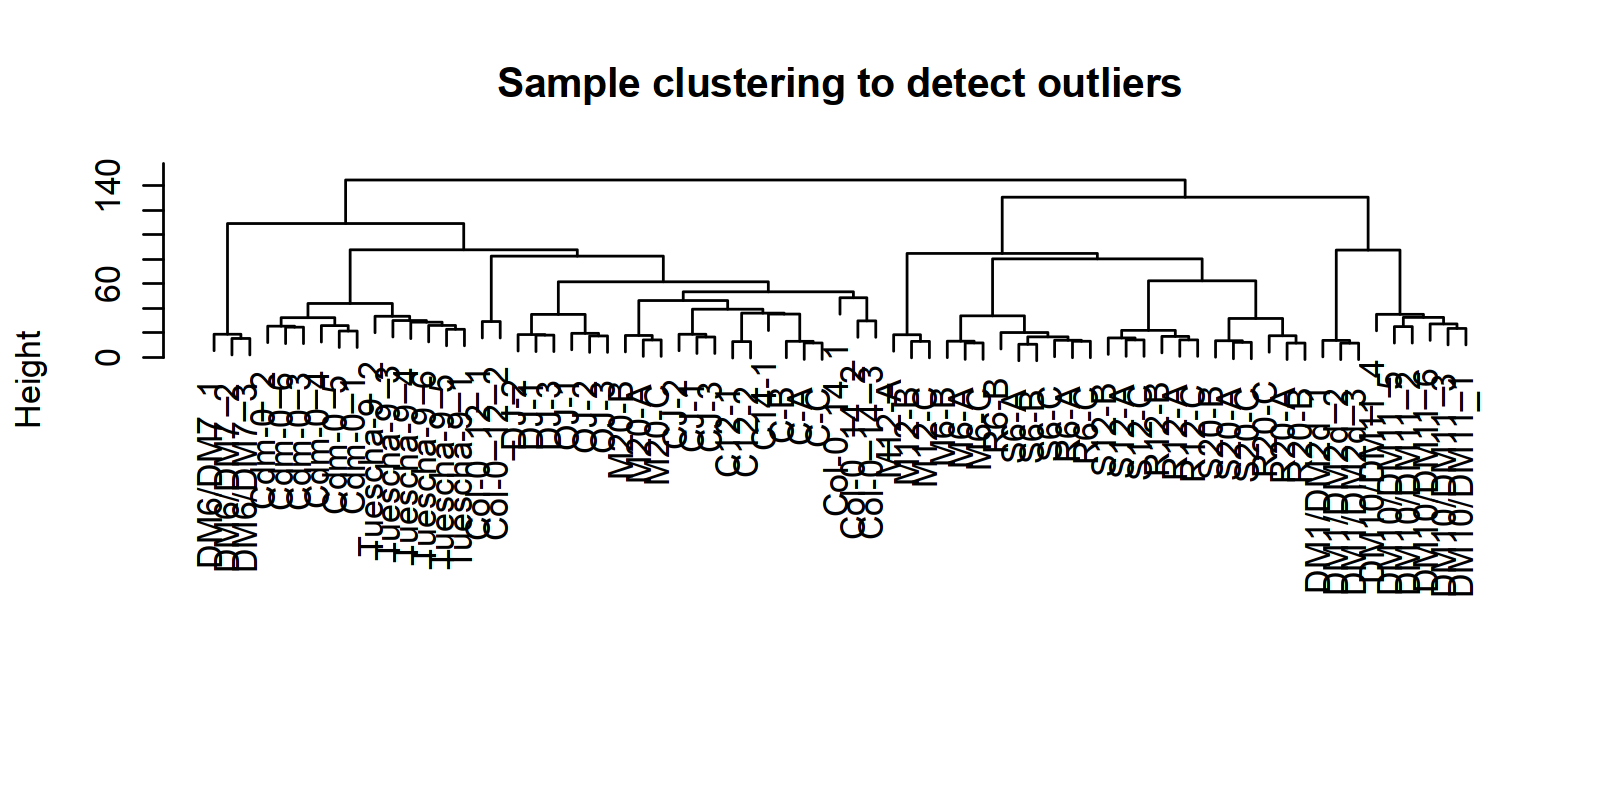

In [17]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res = 200)
## 查看是否有离群样品
sampleTree = hclust(dist(dataExpr), method = "average")
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="")

pdf(file = paste0(plots_path, 'sample_clustering',Sys.time(), '.pdf'), width = 9.5, height = 4)
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex= 0.7)
dev.off()

## Determine Soft threshold (power)

http://pklab.med.harvard.edu/scw2014/WGCNA.html

pickSoftThreshold: will use block size 5461.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 5461 of 5461
   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.30300  9.7300        0.97000    2780    2780.0   3040
2      2  0.86600  5.2100        0.84500    1900    1960.0   2210
3      3  0.92600  2.2500        0.90500    1460    1550.0   1870
4      4  0.87300  1.3000        0.85500    1190    1290.0   1650
5      5  0.71700  0.8030        0.64600     996    1090.0   1500
6      6  0.48500  0.4890        0.33800     851     938.0   1380
7      7  0.21700  0.2760        0.00434     738     814.0   1280
8      8  0.02800  0.0948       -0.22600     647     712.0   1190
9      9  0.00512 -0.0413       -0.21000     572     625.0   1110
10    10  0.05340 -0.1460       -0.10300     509     552.0   1040
11    12  0.18900 -0.3200        0.12700     411     437.0    916
12    14  0.30000 -0.4320        0.31800     337     

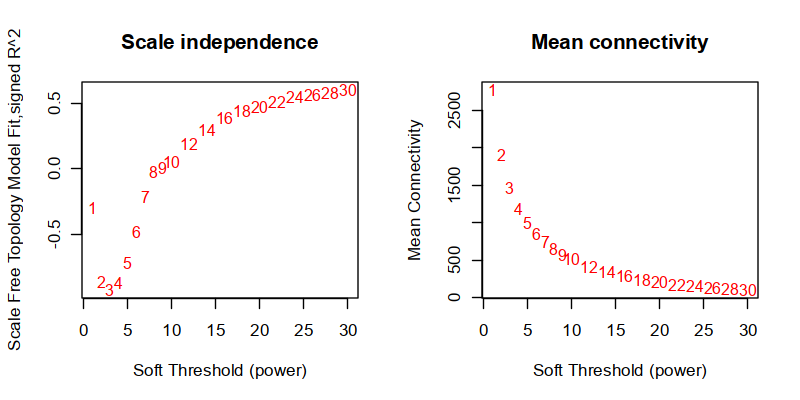

In [18]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res = 100)

powers = c(c(1:10), seq(from = 12, to=30, by=2))
sft = pickSoftThreshold(dataExpr, powerVector=powers, 
                        networkType=type, verbose=5)

par(mfrow = c(1,2))
cex1 = 0.9
# 横轴是Soft threshold (power)，纵轴是无标度网络的评估参数，数值越高，
# 网络越符合无标度特征 (non-scale)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
# 筛选标准。R-square=0.85
abline(h=0.85,col="red")

# Soft threshold与平均连通性
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, 
     cex=cex1, col="red")

In [19]:
power = sft$powerEstimate
power

[1] 2

### construct network, decide power

In [20]:
### 无向网络在power小于15或有向网络power小于30内，没有一个power值可以使
### 无标度网络图谱结构R^2达到0.8，平均连接度较高如在100以上，可能是由于
### 部分样品与其他样品差别太大。这可能由批次效应、样品异质性或实验条件对
### 表达影响太大等造成。可以通过绘制样品聚类查看分组信息和有无异常样品。
### 如果这确实是由有意义的生物变化引起的，也可以使用下面的经验power值。
if (is.na(power)){
  power = ifelse(nSamples<20, ifelse(type == "unsigned", 9, 18),
          ifelse(nSamples<30, ifelse(type == "unsigned", 8, 16),
          ifelse(nSamples<40, ifelse(type == "unsigned", 7, 14),
          ifelse(type == "unsigned", 6, 12))       
          )
          )
}
power

[1] 2

In [21]:
print(paste('calculating power = ' , power) )

[1] "calculating power =  2"


### Generating adjacency and TOM similarity matrices based on the selected softpower

#### manually assign power if softpowder doesn't work

In [22]:
softPower = 14;

#calclute the adjacency matrix
adj= adjacency(dataExpr,type = type, power = softPower);

#turn adjacency matrix into topological overlap to minimize the effects of noise and spurious associations
TOM=TOMsimilarityFromExpr(dataExpr,networkType = type, TOMType = type, power = softPower);

TOM calculation: adjacency..
..will use 127 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [23]:
colnames(TOM) =rownames(TOM) = gene.names
dissTOM=1-TOM

In [24]:
library(flashClust)


Attaching package: ‘flashClust’


The following object is masked from ‘package:fastcluster’:

    hclust


The following object is masked from ‘package:stats’:

    hclust




In [25]:
geneTree = flashClust(as.dist(dissTOM),method="average")

In [26]:
options(repr.plot.width=14, repr.plot.height=10, repr.plot.res = 140)
# Set the minimum module size
minModuleSize = 30

# Module identification using dynamic tree cut

#dynamicMods = cutreeDynamic(dendro = geneTree,  method="hybrid", distM = dissTOM, 
#                            minClusterSize = minModuleSize);
dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM, method="hybrid", deepSplit = 2, pamRespectsDendro = FALSE, minClusterSize = minModuleSize);

#default deepSplit = 2

#the following command gives the module labels and the size of each module. Lable 0 is reserved for unassigned genes
table(dynamicMods)


dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)

# plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut", dendroLabels = FALSE, hang = 0.03, addGuide = TRUE, guideHang = 0.05, main = "Gene dendrogram and module colors")

 ..cutHeight not given, setting it to 0.993  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamicMods
  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
664 643 610 516 440 432 408 349 334 284 148  90  87  87  82  82  78  58  37  32 

dynamicColors
       black         blue        brown         cyan        green  greenyellow 
         408          643          610           87          440          148 
      grey60    lightcyan   lightgreen  lightyellow      magenta midnightblue 
          78           82           58           37          334           82 
        pink       purple          red    royalblue       salmon          tan 
         349          284          432           32           87           90 
   turquoise       yellow 
         664          516 

TOM calculation: adjacency..
..will use 127 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


dynamicMods
  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
664 643 610 516 440 432 408 349 334 284 148  90  87  87  82  82  78  58  37  32 

dynamicColors
       black         blue        brown         cyan        green  greenyellow 
         408          643          610           87          440          148 
      grey60    lightcyan   lightgreen  lightyellow      magenta midnightblue 
          78           82           58           37          334           82 
        pink       purple          red    royalblue       salmon          tan 
         349          284          432           32           87           90 
   turquoise       yellow 
         664          516 

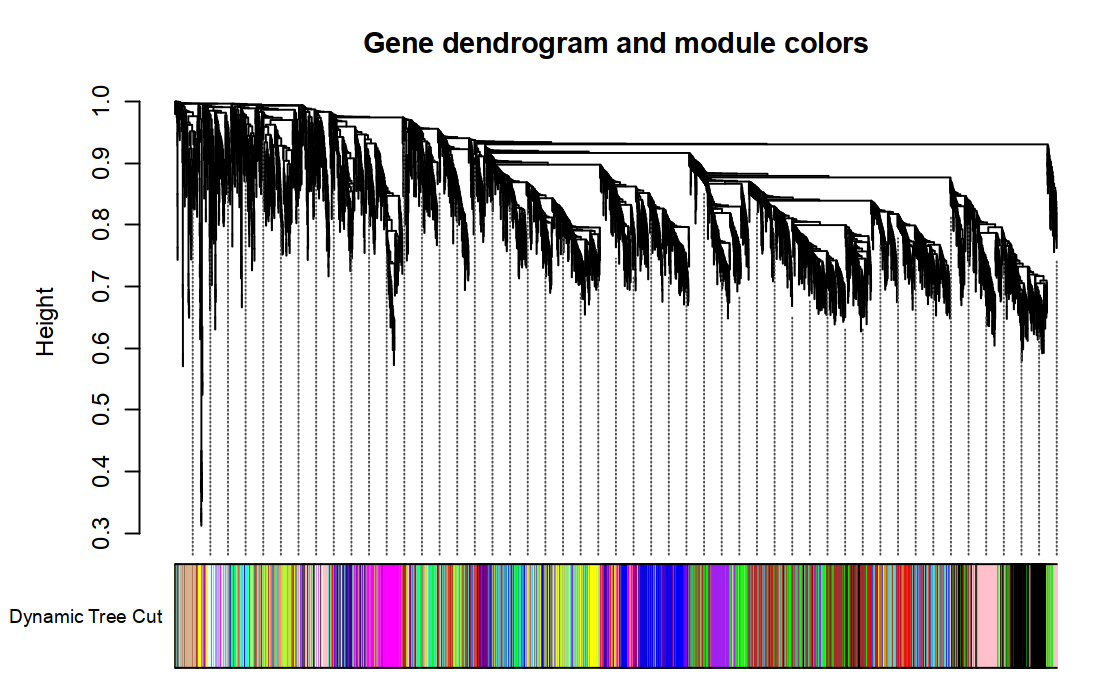

In [27]:
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res = 140)

#discard the unassigned genes, and focus on the rest
restGenes= (dynamicColors != "grey")
diss1=1-TOMsimilarityFromExpr(dataExpr[,restGenes], power = softPower)

#the following command gives the module labels and the size of each module. Lable 0 is reserved for unassigned genes
table(dynamicMods)

#Plot the module assignment under the dendrogram; note: The grey color is reserved for unassigned genes
dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)

colnames(diss1) =rownames(diss1) = gene.names[restGenes]
hier1=flashClust(as.dist(diss1), method="average" )
plotDendroAndColors(hier1, dynamicColors[restGenes], "Dynamic Tree Cut", dendroLabels = FALSE, 
                    hang = 0.03, addGuide = TRUE, guideHang = 0.05, main = "Gene dendrogram and module colors")

## merged mod

https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/FemaleLiver-02-networkConstr-man.pdf

In [28]:
# Calculate eigengenes
MEList = moduleEigengenes(dataExpr, colors = dynamicColors)
MEs = MEList$eigengenes
# Calculate dissimilarity of module eigengenes
MEDiss = 1-cor(MEs);
# Cluster module eigengenes
METree = hclust(as.dist(MEDiss), method = "average");
# Plot the result
sizeGrWindow(7, 6)
plot(METree, main = "Clustering of module eigengenes",
xlab = "", sub = "")

MEDissThres = 0.25 #0.25 default
# Plot the cut line into the dendrogram
abline(h=MEDissThres, col = "red")
# Call an automatic merging function
merge = mergeCloseModules(dataExpr, dynamicColors, cutHeight = MEDissThres, verbose = 3)
# The merged module colors
mergedColors = merge$colors;
# Eigengenes of the new merged modules:
mergedMEs = merge$newMEs;


 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 20 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 11 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 10 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 10 module eigengenes in given set.


In [29]:
table(mergedColors)

mergedColors
       blue        cyan      grey60   lightcyan  lightgreen lightyellow 
       2163          87          78          82         238          37 
       pink      purple      salmon         tan 
        349        2250          87          90 

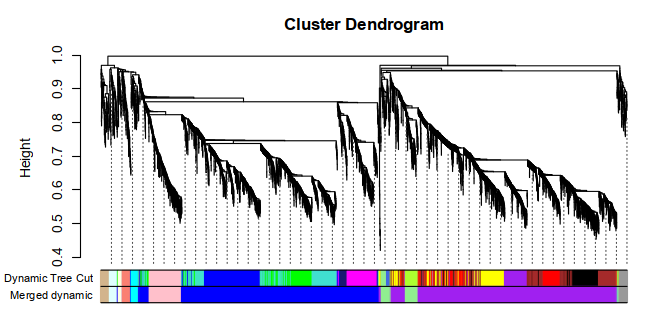

In [30]:

options(repr.plot.width=8.3, repr.plot.height=4, repr.plot.res = 80)

plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors),
c("Dynamic Tree Cut", "Merged dynamic"),
                     autoColorHeight = FALSE,    colorHeight = 0.16,
dendroLabels = FALSE, hang = 0.03,
addGuide = TRUE, guideHang = 0.05)

In [31]:
#sizeGrWindow(12, 9)
pdf(file = paste0(plots_path, 'plotDendroAndColors' ,Sys.time(), '.pdf'),  wi = 3.5, he = 5)

plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors),
c("Dynamic Tree Cut", "Merged dynamic"),
autoColorHeight = FALSE,    colorHeight = 0.16,
dendroLabels = FALSE, hang = 0.03,
addGuide = TRUE, guideHang = 0.05)
dev.off()

png 
  2

In [32]:
library(extrafont)

# Set global font size and family
par(cex=0.8, family="Arial")

# Save the plot
pdf(file = paste0(plots_path, 'plotDendroAndColors' ,Sys.time(), '.pdf'),  wi = 3.3, he = 5, family = "Arial")

plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors),
                    c("Dynamic Tree Cut", "Merged dynamic"),
                    autoColorHeight = FALSE,    
                    colorHeight = 0.16,
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

dev.off()


png 
  2

In [33]:
hubs = chooseTopHubInEachModule(dataExpr, colorh=  mergedColors, power=power, type=type)
hubs

blue        cyan      grey60   lightcyan  lightgreen lightyellow 
"AT3G13910" "AT3G44670" "AT1G12990" "AT2G42910" "AT4G15430" "AT5G08760" 
       pink      purple      salmon         tan 
"AT3G45620" "AT1G75680" "AT5G24470" "AT4G17470"

## export module hub genes from, sorted by connectivity

In [34]:
# the grey module is omitted
topHubs <- function (datExpr, colorh, omitColors = "grey", power = 2, type = "signed", 
    ...) 
{
    # modified from chooseTopHubInEachModule, but return the table of all genes connectivity
    isIndex = FALSE
    modules = names(table(colorh))
    if (!is.na(omitColors)[1]) 
        modules = modules[!is.element(modules, omitColors)]
    if (is.null(colnames(datExpr))) {
        colnames(datExpr) = 1:dim(datExpr)[2]
        isIndex = TRUE
    }
    
    connectivity_table <- data.frame(matrix(ncol = 3)) %>% setNames(c('gene', 'connectivity_rowSums_adj', 'module'))
    hubs = rep(NA, length(modules))
    names(hubs) = modules
    for (m in modules) {
        adj = adjacency(datExpr[, colorh == m], power = power, 
            type = type, ...)

        hub = which.max(rowSums(adj))

        hubs[m] = colnames(adj)[hub]

        sorted_genes <- rowSums(adj) %>% sort(decreasing = T) %>% as.data.frame()  %>%  
                tibble::rownames_to_column() %>% setNames(c('gene', 'connectivity_rowSums_adj')) %>% mutate(module = m)
        connectivity_table <- connectivity_table %>% rbind(sorted_genes)



    }
    if (isIndex) {
        hubs = as.numeric(hubs)
        names(hubs) = modules
    }
    return(connectivity_table %>% na.omit)
}

In [35]:
connectivity_table= topHubs(dataExpr, colorh=  mergedColors, power=power, type=type)

In [36]:
connectivity_table <- connectivity_table %>% left_join(map_id_name, by =c('gene' = 'gene_id'))

In [37]:
connectivity_table %>% group_by(module) %>% top_n(2, wt = connectivity_rowSums_adj)

gene      connectivity_rowSums_adj module      gene_name        
1  AT3G13910 1744.63275               blue        AT3G13910        
2  AT4G23700 1740.13542               blue        CHX17            
3  AT3G44670   70.64439               cyan        DM2H             
4  AT5G45500   69.76106               cyan        AT5G45500        
5  AT1G12990   62.24195               grey60      AT1G12990        
6  AT3G15940   62.04551               grey60      Gene.ID#AT3G15940
7  AT2G42910   61.92981               lightcyan   PRS4             
8  AT4G00620   61.14912               lightcyan   EMB3127          
9  AT4G15430  188.25530               lightgreen  AT4G15430        
10 AT4G27030  188.17856               lightgreen  FADA             
11 AT5G08760   29.27882               lightyellow STMP8            
12 AT2G41010   28.95202               lightyellow CAMBP25          
13 AT3G45620  304.48452               pink        AT3G45620        
14 AT3G47480  303.08891               pink        CML47            
15 AT1G75680 1837.47070               purple      GH9B7            
16 AT1G55360 1830.96151               purple      -1803            
17 AT5G24470   70.79934               salmon      PRR5             
18 AT5G48250   69.91948               salmon      BBX8             
19 AT4G17470   72.75821               tan         CRSH             
20 AT2G39330   72.42287               tan         JAL23

In [38]:
top_50_each_module <- connectivity_table %>% group_by(module) %>% top_n(50, wt = connectivity_rowSums_adj)

In [39]:
require(openxlsx)

wb <- createWorkbook()
for (i in connectivity_table %>% pull(module) %>% unique) {
#     print(i)
    addWorksheet(wb, i)
    writeData(wb, i, connectivity_table %>% filter(module == i))
    
}
saveWorkbook(wb, file = paste0(WGCNA_export_path, "connectivity_each_gene_in_module.xlsx"), overwrite = T)

Loading required package: openxlsx



In [40]:
connectivity_table

gene      connectivity_rowSums_adj module gene_name   
1    AT3G13910 1744.633                 blue   AT3G13910   
2    AT4G23700 1740.135                 blue   CHX17       
3    AT5G42010 1739.162                 blue   AT5G42010   
4    AT5G25930 1738.355                 blue   HSL3        
5    AT4G19370 1736.957                 blue   MWL-2       
6    AT1G23440 1734.441                 blue   AT1G23440   
7    AT1G14870 1733.700                 blue   PCR2        
8    AT5G67310 1733.636                 blue   CYP81G1     
9    AT5G08790 1733.600                 blue   ATAF2       
10   AT2G36780 1732.856                 blue   AT2G36780   
11   AT3G05360 1732.752                 blue   RLP30       
12   AT3G49780 1731.712                 blue   PSK4        
13   AT2G30750 1731.543                 blue   CYP71A12    
14   AT2G46500 1731.315                 blue   PI4K GAMMA 4
15   AT1G63720 1729.751                 blue   AT1G63720   
16   AT1G62300 1729.725                 blue   WRKY6       
17   AT4G21534 1728.812                 blue   SPHK2       
18   AT1G48490 1727.422                 blue   IRE3        
19   AT3G63380 1727.151                 blue   ACA12       
20   AT3G54150 1726.336                 blue   EFD         
21   AT3G12740 1725.301                 blue   ALIS1       
22   AT1G22400 1725.282                 blue   UGT85A1     
23   AT3G25610 1724.812                 blue   ALA10       
24   AT5G54840 1724.022                 blue   SGP1        
25   AT1G08940 1723.611                 blue   AT1G08940   
26   AT2G45570 1722.189                 blue   CYP76C2     
27   AT3G50260 1721.850                 blue   CEJ1        
28   AT3G58750 1720.985                 blue   CSY2        
29   AT1G09970 1719.925                 blue   LRR XI-23   
30   AT5G26030 1719.717                 blue   FC1         
⋮    ⋮         ⋮                        ⋮      ⋮           
5432 AT5G42650 63.13098                 tan    AOS         
5433 AT1G56650 62.94414                 tan    PAP1        
5434 AT4G22755 62.66442                 tan    SMO1-3      
5435 AT5G44050 62.37339                 tan    ATDTX28     
5436 AT2G14750 62.16478                 tan    APK         
5437 AT5G48010 61.02553                 tan    THAS1       
5438 AT4G21910 60.92252                 tan    AT4G21910   
5439 AT2G43535 60.86404                 tan    AT2G43535   
5440 AT4G24350 60.77629                 tan    AT4G24350   
5441 AT4G19430 60.67875                 tan    AT4G19430   
5442 AT1G70700 60.15096                 tan    TIFY7       
5443 AT5G47990 60.10056                 tan    CYP705A5    
5444 AT1G14250 60.00762                 tan    AT1G14250   
5445 AT4G15765 59.62610                 tan    AT4G15765   
5446 AT2G22330 58.88282                 tan    CYP79B3     
5447 AT3G16500 58.15957                 tan    PAP1        
5448 AT1G69480 57.69849                 tan    AT1G69480   
5449 AT3G44260 57.44093                 tan    CAF1a       
5450 AT1G76790 57.29657                 tan    IGMT5       
5451 AT5G05590 57.03804                 tan    PAI2        
5452 AT3G09260 56.99631                 tan    PYK10       
5453 AT5G26260 56.00443                 tan    AT5G26260   
5454 AT4G27860 55.70559                 tan    MEB1        
5455 AT3G44310 55.13253                 tan    NIT1        
5456 AT2G37040 53.68329                 tan    PAL1        
5457 AT1G43800 52.56279                 tan    FTM1        
5458 AT3G16450 49.86153                 tan    JAL33       
5459 AT5G26280 49.60228                 tan    AT5G26280   
5460 AT3G16430 49.53438                 tan    JAL31       
5461 AT1G32090 43.54115                 tan    OSCA1.8

In [41]:
# Rename to moduleColors
moduleColors = mergedColors
# Construct numerical labels corresponding to the colors
colorOrder = c("grey", standardColors(50));
moduleLabels = match(moduleColors, colorOrder)-1;
MEs = mergedMEs;
# Save module colors and labels for use in subsequent parts
#save(MEs, moduleLabels, moduleColors, geneTree, file = "FemaleLiver-02-networkConstruction-stepByStep.RData")

In [42]:
moduleColors %>% unique()
MEs %>% head(2)

[1] "purple"      "blue"        "lightgreen"  "pink"        "salmon"     
 [6] "tan"         "cyan"        "lightcyan"   "grey60"      "lightyellow"

MElightgreen MEpurple    MElightcyan MEtan       MEblue     
DM1/DM2d_1 -0.15568324  -0.20740615 -0.18965716 -0.14024183  0.14116848
Col-0_12_1 -0.03731731   0.07387779 -0.05593348 -0.02398296 -0.07249085
           MEpink      MEcyan     MElightyellow MEgrey60   MEsalmon  
DM1/DM2d_1  0.27154391 0.14785767  0.18693560   0.15760467 0.03394604
Col-0_12_1 -0.03583691 0.01818309 -0.01265133   0.03415797 0.06768786

In [43]:
#set the diagonal of the dissimilarity to NA 
diag(diss1) = NA;

#Visualize the Tom plot. Raise the dissimilarity matrix to the power of 4 to bring out the module structure
#sizeGrWindow(7,7)

pdf(file = paste0(plots_path, 'TOMplot' ,Sys.time(), '.pdf'),  wi = 6, he = 12)
TOMplot(diss1, hier1, as.character(moduleColors[restGenes]))
dev.off()

png 
  2

png 
  2

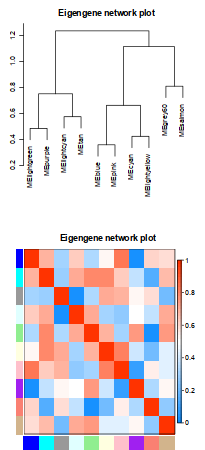

In [44]:
options(repr.plot.width=4.1, repr.plot.height=9, repr.plot.res = 50)

# Set up the font family and size
par(family = "Arial", cex = 0.8)

MEList = moduleEigengenes(dataExpr, colors = moduleColors)
MEs = MEList$eigengenes

# Plot with the specified font settings
plotEigengeneNetworks(MEs, "Eigengene network plot", marDendro = c(2,3 ,3,2), marHeatmap = c(2, 3, 3, 2))

# Save the plot to a PDF file with the specified font settings
pdf(file = paste0(plots_path, 'ME_tree_' ,Sys.time(), '.pdf'),  wi = 3.1, he = 7.3, family = "Arial")
par(cex = 0.8)  # Set the font size to 8 points in the PDF device
plotEigengeneNetworks(MEs, "", marDendro = c(2,3 ,3,2), marHeatmap = c(2, 3, 3, 2))
dev.off()


## Export Merged Moduels for Cytoscape

In [45]:
moduleColors %>% unique()

[1] "purple"      "blue"        "lightgreen"  "pink"        "salmon"     
 [6] "tan"         "cyan"        "lightcyan"   "grey60"      "lightyellow"

In [48]:
# Recalculate topological overlap if needed
TOM = TOMsimilarityFromExpr(dataExpr, power = 6);
threshold_ = 0.01
node_edge_path <- paste0(WGCNA_export_path, '/', threshold_, 'edge_node' , '/')
dir.create(node_edge_path)
# Select modules
modules = c('purple','darkred','midnightblue','salmon',
            'darkturquoise','greenyellow','darkgreen','tan')
# Select module probes
probes = names(dataExpr)
inModule = is.finite(match(moduleColors, modules));
modProbes = probes[inModule];
modGenes = modProbes
# Select the corresponding Topological Overlap
modTOM = TOM[inModule, inModule];

dimnames(modTOM) = list(modProbes, modProbes)
# Export the network into edge and node list files Cytoscape can read
cyt = exportNetworkToCytoscape(modTOM,
    edgeFile = paste(node_edge_path, '/', "edges-", paste(modules, collapse="-"), ".txt", sep=""),
    nodeFile = paste(node_edge_path, '/', "nodes-", paste(modules, collapse="-"), ".txt", sep=""),
    weighted = TRUE,
    threshold = threshold_,
    nodeNames = modProbes,
    altNodeNames = modGenes,
    nodeAttr = moduleColors[inModule])

TOM calculation: adjacency..
..will use 127 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


Warning message in dir.create(node_edge_path):
“'./WGCNA_output_all_test/0.01edge_node' already exists”


In [49]:
# Recalculate topological overlap if needed
TOM = TOMsimilarityFromExpr(dataExpr, power = 6);
threshold_ = 0.01
node_edge_path <- paste0(WGCNA_export_path, '/', threshold_, 'edge_node' , '/')
# Select modules
modules = moduleColors %>% unique()
# Select module probes
probes = names(dataExpr)
inModule = is.finite(match(moduleColors, modules));
modProbes = probes[inModule];
modGenes = modProbes
# Select the corresponding Topological Overlap
modTOM = TOM[inModule, inModule];

dimnames(modTOM) = list(modProbes, modProbes)
# Export the network into edge and node list files Cytoscape can read
cyt = exportNetworkToCytoscape(modTOM,
    edgeFile = paste(node_edge_path, '/', "edges-", paste(modules, collapse="-"), ".txt", sep=""),
    nodeFile = paste(node_edge_path, '/', "nodes-", paste(modules, collapse="-"), ".txt", sep=""),
    weighted = TRUE,
    threshold = threshold_,
    nodeNames = modProbes,
    altNodeNames = modGenes,
    nodeAttr = moduleColors[inModule])

TOM calculation: adjacency..
..will use 127 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


## edges and nodes of top n each module 

In [50]:
top_50_each_module_edge <- cyt[[1]] %>% semi_join(top_50_each_module, by = c('fromNode' = 'gene')) %>% 
    semi_join(top_50_each_module, by = c('toNode' = 'gene'))
top_50_each_module_edge %>%    write.csv(paste0(node_edge_path, '/', "edges-",'top50_each_module', ".csv"), row.names = F, quote = F)

In [51]:
top_50_each_module_edge_node <- cyt[[2]] %>% semi_join(top_50_each_module, by = c('nodeName' = 'gene')) 

top_50_each_module_edge_node %>%
    write.csv(paste0(node_edge_path, '/', "nodes-",'top50_each_module', ".csv"), row.names = F, quote = F)

In [52]:
connectivity_table %>% group_by(module) %>% top_n(5, wt = connectivity_rowSums_adj) %>% 
    mutate(hub = 'yes') %>% write.csv(paste0(node_edge_path, '/', "5hub_each_module.csv"), row.names = F, quote = F)

In [53]:
# Recalculate topological overlap if needed
TOM = TOMsimilarityFromExpr(dataExpr, power = 6);
threshold_ = 0.01
node_edge_path <- paste0(WGCNA_export_path, '/', threshold_, 'edge_node' , '/')
create_directory_if_not_exists(node_edge_path)
for (color in moduleColors %>% unique()) {
    if (color == 'grey') {
        next }
    # Select modules
    modules = color
    # Select module probes
    probes = names(dataExpr)
    inModule = is.finite(match(moduleColors, modules));
    modProbes = probes[inModule];
    modGenes = modProbes
    # Select the corresponding Topological Overlap
    modTOM = TOM[inModule, inModule];

    dimnames(modTOM) = list(modProbes, modProbes)
    # Export the network into edge and node list files Cytoscape can read
    cyt = exportNetworkToCytoscape(modTOM,
    edgeFile = paste(  node_edge_path, color,'-', threshold_,  "-edges-", paste(modules, collapse="-"), ".txt", sep=""),
    nodeFile = paste(node_edge_path, color, '-', threshold_, "-nodes-", paste(modules, collapse="-"), ".txt", sep=""),
    weighted = TRUE,
    threshold = threshold_ ,
    nodeNames = modProbes,
    altNodeNames = modGenes,
    nodeAttr = moduleColors[inModule])
}

TOM calculation: adjacency..
..will use 127 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [54]:
create_directory_if_not_exists(WGCNA_export_path)

In [55]:
cyt_merged_0 = exportNetworkToCytoscape(TOM,
             edgeFile = paste(WGCNA_export_path,  "/0_all_mdoules_edges.txt", sep=""),
             nodeFile = paste(WGCNA_export_path, "/0_all_mdoules_nodes.txt", sep=""),
             weighted = TRUE, threshold = 0,
             nodeNames = probes, nodeAttr = moduleColors)
node_data <- cyt_merged_0$nodeData[, c(1,3)]
names(node_data) <- c('gene', 'module')
nrow(node_data)
node_data %>% sample_n(2)

[1] 5461

gene      module
1 AT1G03080 blue  
2 AT2G31090 blue

In [56]:
node_n <- node_data %>% group_by(module) %>% summarise(n= n()) %>% mutate(module = paste0('ME', module))

## Module-trait relationships

In [57]:
traits <-readxl::read_excel("./refs/3-DM_shoots_root_JC14_adr1s_pathogen.xlsx") %>% filter(tissue =='Shoot')
traits <- traits %>% tibble::column_to_rownames( var = "short_name")  %>%  mutate( 
    `DM1/DM2d` = case_when(
  group2 %in% c("DM1/DM2d") ~ 1,
  group2 %in% c("Col-0_12") ~ -1), 
    
    `DM6/DM7` = case_when(
  group2 %in% c("DM6/DM7") ~ 1,
  group2 %in% c("Col-0_14") ~ -1),    
    
    `2DMs_vs_WT` = case_when(
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ 1,
  group2 %in% c("Col-0_14", "Col-0_12") ~ -1), 
    
    `DM1_DM2d_adr1s` = case_when(
  group2 %in% c( "DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("Col-0_12" ) ~ -1), 
    
    `DM1_DM2d_adr1s` = case_when(
  group2 %in% c("DM6/DM7_adr1s" ) ~ 1,
  group2 %in% c("Col-0_14" ) ~ -1), 
    
    `Col-0_adr1s` = case_when(
  group2 %in% c("Col-0_adr1s" ) ~ 1,
  group2 %in% c("Col-0_12" ) ~ -1), 
    
    `DM1/DM2d_vs_DM6/DM7`  = case_when(
  group2 %in% c("DM1/DM2d" ) ~ 1,
  group2 %in% c("DM6/DM7" ) ~ -1), 
    
    `DM1/DM2d_adr1s_vs_DM6/DM7_adr1s`  = case_when(
  group2 %in% c("DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("DM6/DM7_adr1s" ) ~ -1), 

     `DM_adr1s_vs_Col-0_adr1s` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c('Col-0_adr1s' ) ~ -1), 

    
    `2adr1s_vs_WT` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("Col-0_14", "Col-0_12" ) ~ -1), 
    
     `3adr1s_vs_WT` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s", 'Col-0_adr1s') ~ 1,
  group2 %in% c("Col-0_14", "Col-0_12" ) ~ -1), 

     `2adr1s_vs_DM` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ -1), 
    
     `3adr1s_vs_DM` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s", 'Col-0_adr1s' ) ~ 1,
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ -1)
    
) 

traitData <- traits  %>%  select(`DM1/DM2d`,`DM6/DM7`,`2DMs_vs_WT`,`DM1_DM2d_adr1s`,
        DM1_DM2d_adr1s,`Col-0_adr1s`,`2adr1s_vs_WT`,
    `3adr1s_vs_WT`,`2adr1s_vs_DM`,`3adr1s_vs_DM`,
        `DM1/DM2d_vs_DM6/DM7`,`DM1/DM2d_adr1s_vs_DM6/DM7_adr1s`, `DM_adr1s_vs_Col-0_adr1s`,
                                 DAS) #%>% filter(!grepl('Tuescha|Cdm|DM11', rownames(traits)))


traitData

DM1/DM2d DM6/DM7 2DMs_vs_WT DM1_DM2d_adr1s Col-0_adr1s 2adr1s_vs_WT
DM1/DM2d_1   1       NA       1         NA             NA          NA          
Col-0_12_1  -1       NA      -1         NA             -1          -1          
DM1/DM2d_2   1       NA       1         NA             NA          NA          
Col-0_12_2  -1       NA      -1         NA             -1          -1          
DM1/DM2d_3   1       NA       1         NA             NA          NA          
DM6/DM7_1   NA        1       1         NA             NA          NA          
Col-0_14_1  NA       -1      -1         -1             NA          -1          
DM6/DM7_2   NA        1       1         NA             NA          NA          
Col-0_14_2  NA       -1      -1         -1             NA          -1          
DM6/DM7_3   NA        1       1         NA             NA          NA          
Col-0_14_3  NA       -1      -1         -1             NA          -1          
DM10/DM11_6 NA       NA      NA         NA             NA          NA          
DM10/DM11_5 NA       NA      NA         NA             NA          NA          
DM10/DM11_4 NA       NA      NA         NA             NA          NA          
DM10/DM11_3 NA       NA      NA         NA             NA          NA          
DM10/DM11_2 NA       NA      NA         NA             NA          NA          
DM10/DM11_1 NA       NA      NA         NA             NA          NA          
Tuescha-9_6 NA       NA      NA         NA             NA          NA          
Tuescha-9_5 NA       NA      NA         NA             NA          NA          
Tuescha-9_4 NA       NA      NA         NA             NA          NA          
Tuescha-9_3 NA       NA      NA         NA             NA          NA          
Tuescha-9_2 NA       NA      NA         NA             NA          NA          
Tuescha-9_1 NA       NA      NA         NA             NA          NA          
Cdm-0_6     NA       NA      NA         NA             NA          NA          
Cdm-0_5     NA       NA      NA         NA             NA          NA          
Cdm-0_4     NA       NA      NA         NA             NA          NA          
Cdm-0_3     NA       NA      NA         NA             NA          NA          
Cdm-0_2     NA       NA      NA         NA             NA          NA          
Cdm-0_1     NA       NA      NA         NA             NA          NA          
C12-1       -1       NA      -1         NA             -1          -1          
⋮           ⋮        ⋮       ⋮          ⋮              ⋮           ⋮           
C-A         NA       NA      NA         NA             NA          NA          
C-B         NA       NA      NA         NA             NA          NA          
C-C         NA       NA      NA         NA             NA          NA          
M6-A        NA       NA      NA         NA             NA          NA          
M6-B        NA       NA      NA         NA             NA          NA          
M6-C        NA       NA      NA         NA             NA          NA          
R6-A        NA       NA      NA         NA             NA          NA          
R6-B        NA       NA      NA         NA             NA          NA          
R6-C        NA       NA      NA         NA             NA          NA          
S6-A        NA       NA      NA         NA             NA          NA          
S6-B        NA       NA      NA         NA             NA          NA          
S6-C        NA       NA      NA         NA             NA          NA          
M12-A       NA       NA      NA         NA             NA          NA          
M12-B       NA       NA      NA         NA             NA          NA          
M12-C       NA       NA      NA         NA             NA          NA          
R12-A       NA       NA      NA         NA             NA          NA          
R12-B       NA       NA      NA         NA             NA          NA          
R12-C       NA       NA      NA         NA             NA          NA          
S12-A       

In [58]:
readxl::read_excel("./refs/3-DM_shoots_root_JC14_adr1s_pathogen.xlsx") %>% filter(tissue =='Shoot')

short_name  sample_Names     genotype tissue DM        DAS accession media
1  DM1/DM2d_1  DM1/DM2d_Shoot_1 DM       Shoot  DM1/DM2d  12  Col-0     1/2MS
2  Col-0_12_1  Col-0_Shoot_1    WT       Shoot  WT        12  Col-0     1/2MS
3  DM1/DM2d_2  DM1/DM2d_Shoot_2 DM       Shoot  DM1/DM2d  12  Col-0     1/2MS
4  Col-0_12_2  Col-0_Shoot_2    WT       Shoot  WT        12  Col-0     1/2MS
5  DM1/DM2d_3  DM1/DM2d_Shoot_3 DM       Shoot  DM1/DM2d  12  Col-0     1/2MS
6  DM6/DM7_1   DM6/DM7_Shoot_1  DM       Shoot  DM6/DM7   14  Col-0     1/2MS
7  Col-0_14_1  Col-0_Shoot_1    WT       Shoot  WT        14  Col-0     1/2MS
8  DM6/DM7_2   DM6/DM7_Shoot_2  DM       Shoot  DM6/DM7   14  Col-0     1/2MS
9  Col-0_14_2  Col-0_Shoot_2    WT       Shoot  WT        14  Col-0     1/2MS
10 DM6/DM7_3   DM6/DM7_Shoot_3  DM       Shoot  DM6/DM7   14  Col-0     1/2MS
11 Col-0_14_3  Col-0_Shoot_3    WT       Shoot  WT        14  Col-0     1/2MS
12 DM10/DM11_6 DM10/DM11_6      DM       Shoot  DM10/DM11 10  DM10/DM11 Soil 
13 DM10/DM11_5 DM10/DM11_5      DM       Shoot  DM10/DM11 10  DM10/DM11 Soil 
14 DM10/DM11_4 DM10/DM11_4      DM       Shoot  DM10/DM11 10  DM10/DM11 Soil 
15 DM10/DM11_3 DM10/DM11_3      DM       Shoot  DM10/DM11 10  DM10/DM11 Soil 
16 DM10/DM11_2 DM10/DM11_2      DM       Shoot  DM10/DM11 10  DM10/DM11 Soil 
17 DM10/DM11_1 DM10/DM11_1      DM       Shoot  DM10/DM11 10  DM10/DM11 Soil 
18 Tuescha-9_6 Tuescha-9_6      WT       Shoot  WT        10  Tuescha-9 Soil 
19 Tuescha-9_5 Tuescha-9_5      WT       Shoot  WT        10  Tuescha-9 Soil 
20 Tuescha-9_4 Tuescha-9_4      WT       Shoot  WT        10  Tuescha-9 Soil 
21 Tuescha-9_3 Tuescha-9_3      WT       Shoot  WT        10  Tuescha-9 Soil 
22 Tuescha-9_2 Tuescha-9_2      WT       Shoot  WT        10  Tuescha-9 Soil 
23 Tuescha-9_1 Tuescha-9_1      WT       Shoot  WT        10  Tuescha-9 Soil 
24 Cdm-0_6     Cdm-0_6          WT       Shoot  WT        10  Cdm-0     Soil 
25 Cdm-0_5     Cdm-0_5          WT       Shoot  WT        10  Cdm-0     Soil 
26 Cdm-0_4     Cdm-0_4          WT       Shoot  WT        10  Cdm-0     Soil 
27 Cdm-0_3     Cdm-0_3          WT       Shoot  WT        10  Cdm-0     Soil 
28 Cdm-0_2     Cdm-0_2          WT       Shoot  WT        10  Cdm-0     Soil 
29 Cdm-0_1     Cdm-0_1          WT       Shoot  WT        10  Cdm-0     Soil 
30 C12-1       Col-0_12_1       WT       Shoot  WT        12  Col-0     1/2MS
⋮  ⋮           ⋮                ⋮        ⋮      ⋮         ⋮   ⋮         ⋮    
42 C-A         C-A              WT       Shoot  WT        12  Col-0     1/2MS
43 C-B         C-B              WT       Shoot  WT        12  Col-0     1/2MS
44 C-C         C-C              WT       Shoot  WT        12  Col-0     1/2MS
45 M6-A        M6-A             WT       Shoot  WT        12  Col-0     1/2MS
46 M6-B        M6-B             WT       Shoot  WT        12  Col-0     1/2MS
47 M6-C        M6-C             WT       Shoot  WT        12  Col-0     1/2MS
48 R6-A        R6-A             WT       Shoot  WT        12  Col-0     1/2MS
49 R6-B        R6-B             WT       Shoot  WT        12  Col-0     1/2MS
50 R6-C        R6-C             WT       Shoot  WT        12  Col-0     1/2MS
51 S6-A        S6-A             WT       Shoot  WT        12  Col-0     1/2MS
52 S6-B        S6-B             WT       Shoot  WT        12  Col-0     1/2MS
53 S6-C        S6-C             WT       Shoot  WT        12  Col-0     1/2MS
54 M12-A       M12-A            WT       Shoot  WT        12  Col-0     1/2MS
55 M12-B       M12-B            WT       Shoot  WT        12  Col-0     1/2MS
56 M12-C       M12-C            WT       Shoot  WT        12  Col-0     1/2MS
57 R12-A       R12-A            WT       Shoot  WT        12  Col-0     1/2MS
58 R12-B       R12-B            WT       Shoot  WT        12  Col-0     1/2MS
59 R12-C       R12-C            WT       Shoot  WT        12  Col-0     1/2MS
60 S12-A       S12-A            WT       Shoot  WT        12  Col-0     1/2MS
61 S12-B       S12-B     

In [59]:
traits <-readxl::read_excel("./refs/3-DM_shoots_root_JC14_adr1s_pathogen.xlsx") %>% filter(tissue =='Shoot')
traits <- traits %>% tibble::column_to_rownames( var = "short_name")  %>%  mutate( 

    `Rps4_vs_Rpt2_20h`  = case_when(
  group2 %in% c( "AvrRps4-20h") ~ 1,
  group2 %in% c("AvrRpt2-20h" ) ~ -1), 
    
  #   `Avr_vs_DM6/DM7_DM1/DM2d`  = case_when(
  # group2 %in% c("AvrRps4-20h",'AvrRpt2-20h' ) ~ 1,
  # group2 %in% c("DM1/DM2d", 'DM6/DM7') ~ -1), 
    
    `DM1/DM2d_vs_DM6/DM7`  = case_when(
  group2 %in% c("DM1/DM2d" ) ~ 1,
  group2 %in% c("DM6/DM7" ) ~ -1), 
    
    `DM1/DM2d_adr1s_vs_DM6/DM7_adr1s`  = case_when(
  group2 %in% c("DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("DM6/DM7_adr1s" ) ~ -1), 

     `2adr1s_vs_DM` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ -1), 
    
    `DM_vs_WT` = case_when(
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ 1,
  group2 %in% c('Col-0_14', 'Col-0_12') ~ -1), 
    
        `Avr_vs_Mock` = case_when(
  group2 %in% c("AvrRps4-20h", "AvrRpt2-20h") ~ 1,
  group2 %in% c('Mock-20h' ) ~ -1), 
    
    `DM_vs_Avr` = case_when(
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ 1,
  group2 %in% c("AvrRps4-20h", "AvrRpt2-20h") ~ -1), 
      
    
    
) 

traitData <- traits  %>%  select(18:ncol(traits))


traitData

Rps4_vs_Rpt2_20h DM1/DM2d_vs_DM6/DM7
DM1/DM2d_1  NA                1                 
Col-0_12_1  NA               NA                 
DM1/DM2d_2  NA                1                 
Col-0_12_2  NA               NA                 
DM1/DM2d_3  NA                1                 
DM6/DM7_1   NA               -1                 
Col-0_14_1  NA               NA                 
DM6/DM7_2   NA               -1                 
Col-0_14_2  NA               NA                 
DM6/DM7_3   NA               -1                 
Col-0_14_3  NA               NA                 
DM10/DM11_6 NA               NA                 
DM10/DM11_5 NA               NA                 
DM10/DM11_4 NA               NA                 
DM10/DM11_3 NA               NA                 
DM10/DM11_2 NA               NA                 
DM10/DM11_1 NA               NA                 
Tuescha-9_6 NA               NA                 
Tuescha-9_5 NA               NA                 
Tuescha-9_4 NA               NA                 
Tuescha-9_3 NA               NA                 
Tuescha-9_2 NA               NA                 
Tuescha-9_1 NA               NA                 
Cdm-0_6     NA               NA                 
Cdm-0_5     NA               NA                 
Cdm-0_4     NA               NA                 
Cdm-0_3     NA               NA                 
Cdm-0_2     NA               NA                 
Cdm-0_1     NA               NA                 
C12-1       NA               NA                 
⋮           ⋮                ⋮                  
C-A         NA               NA                 
C-B         NA               NA                 
C-C         NA               NA                 
M6-A        NA               NA                 
M6-B        NA               NA                 
M6-C        NA               NA                 
R6-A        NA               NA                 
R6-B        NA               NA                 
R6-C        NA               NA                 
S6-A        NA               NA                 
S6-B        NA               NA                 
S6-C        NA               NA                 
M12-A       NA               NA                 
M12-B       NA               NA                 
M12-C       NA               NA                 
R12-A       NA               NA                 
R12-B       NA               NA                 
R12-C       NA               NA                 
S12-A       NA               NA                 
S12-B       NA               NA                 
S12-C       NA               NA                 
M20-A       NA               NA                 
M20-B       NA               NA                 
M20-C       NA               NA                 
R20-A       -1               NA                 
R20-B       -1               NA                 
R20-C       -1               NA                 
S20-A        1               NA                 
S20-B        1               NA                 
S20-C        1               NA                 
            DM1/DM2d_adr1s_vs_DM6/DM7_adr1s 2adr1s_vs_DM DM_vs_WT Avr_vs_Mock
DM1/DM2d_1  NA                              -1            1       NA         
Col-0_12_1  NA                              NA           -1       NA         
DM1/DM2d_2  NA                              -1            1       NA         
Col-0_12_2  NA                              NA           -1       NA         
DM1/DM2d_3  NA                              -1            1       NA         
DM6/DM7_1   NA                              -1            1       NA         
Col-0_14_1  NA                              NA           -1       NA         
DM6/DM7_2   NA                              -1            1       NA         
Col-0_14_2  NA                              NA           -1       NA         
DM6/DM7_3   NA                              -1            1       NA         
Col-0_14_3  NA                              NA           -1       NA         
DM10/DM11_6 NA                        

In [60]:
rownames(MEs)

[1] "DM1/DM2d_1"  "Col-0_12_1"  "DM1/DM2d_2"  "Col-0_12_2"  "DM1/DM2d_3" 
 [6] "DM6/DM7_1"   "Col-0_14_1"  "DM6/DM7_2"   "Col-0_14_2"  "DM6/DM7_3"  
[11] "Col-0_14_3"  "DM10/DM11_6" "DM10/DM11_5" "DM10/DM11_4" "DM10/DM11_3"
[16] "DM10/DM11_2" "DM10/DM11_1" "Tuescha-9_6" "Tuescha-9_5" "Tuescha-9_4"
[21] "Tuescha-9_3" "Tuescha-9_2" "Tuescha-9_1" "Cdm-0_6"     "Cdm-0_5"    
[26] "Cdm-0_4"     "Cdm-0_3"     "Cdm-0_2"     "Cdm-0_1"     "C12-1"      
[31] "C12-2"       "C14-1"       "DJ-1"        "DJ-2"        "DJ-3"       
[36] "CJ-1"        "CJ-2"        "CJ-3"        "OJ-1"        "OJ-2"       
[41] "OJ-3"        "C-A"         "C-B"         "C-C"         "M6-A"       
[46] "M6-B"        "M6-C"        "R6-A"        "R6-B"        "R6-C"       
[51] "S6-A"        "S6-B"        "S6-C"        "M12-A"       "M12-B"      
[56] "M12-C"       "R12-A"       "R12-B"       "R12-C"       "S12-A"      
[61] "S12-B"       "S12-C"       "M20-A"       "M20-B"       "M20-C"      
[66] "R20-A"       "R20-B"       "R20-C"       "S20-A"       "S20-B"      
[71] "S20-C"

In [61]:
MEs %>% nrow
# rownames(MEs)
# rownames(traitData)
all(rownames(MEs) == rownames(traitData))

[1] 71

[1] TRUE

In [62]:
# Correlate traits --------------------------------------------------------
options(repr.plot.width=20, repr.plot.height=12, repr.plot.res = 140)
 
#Define number of genes and samples
nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)
#Recalculate MEs with color labels
MEs0 = moduleEigengenes(dataExpr, moduleColors)$eigengenes
MEs = orderMEs(MEs0)
moduleTraitCor = cor(MEs, traitData, use= "p")
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples)

 
#Print correlation heatmap between modules and traits
textMatrix= paste(signif(moduleTraitCor, 2), "\n(",
                        signif(moduleTraitPvalue, 1), ")", sep= "")
dim(textMatrix)= dim(moduleTraitCor)

# par(mar= c(9, 15, 3, 3))
# module_relationship_plot <- labeledHeatmap(Matrix= moduleTraitCor,
#             xLabels= names(traitData),
#             yLabels= names(MEs),
#             ySymbols= names(MEs),
#             colorLabels= FALSE,
#             colors= blueWhiteRed(20, gamma = 0.3, endSaturation = 0.3),
#             textMatrix= textMatrix,
#             setStdMargins= FALSE,
#             xLabelsAngle =35,
#             cex.text= 1,
#             zlim= c(-1,1),
#             main= paste("Module-trait relationships")
#                                           )

pdf(file = paste0(plots_path, "module_trait_merged.pdf"),  wi = 14, he = 9)

par(mar= c(9, 7, 3, 3))
module_relationship_plot <- labeledHeatmap(Matrix= moduleTraitCor,
            xLabels= names(traitData),
            yLabels= names(MEs),
            ySymbols= names(MEs),
            colorLabels= FALSE,
            colors= blueWhiteRed(20, gamma =0.3 , endSaturation = 0.3),
            textMatrix= textMatrix,
            setStdMargins= FALSE,
            xLabelsAngle =35,
            cex.text= 1,
            zlim= c(-1,1),
            main= paste("Module-trait relationships")
                                          )

dev.off()

png 
  2

In [63]:
names(traitData)

[1] "Rps4_vs_Rpt2_20h"                "DM1/DM2d_vs_DM6/DM7"            
[3] "DM1/DM2d_adr1s_vs_DM6/DM7_adr1s" "2adr1s_vs_DM"                   
[5] "DM_vs_WT"                        "Avr_vs_Mock"                    
[7] "DM_vs_Avr"

# customized trait plot

In [64]:
module_trait_df <- moduleTraitCor %>%
  as.data.frame() %>%
  tibble::rownames_to_column(var = 'Module') %>%
  pivot_longer(cols = -Module, names_to = 'Trait', values_to = 'Correlation') %>% 
    left_join(
        moduleTraitPvalue %>%
  as.data.frame() %>%
  tibble::rownames_to_column(var = 'Module') %>%
  pivot_longer(cols = -Module, names_to = 'Trait', values_to = 'Pvalue'),
    by = c('Module' = 'Module', 'Trait' = 'Trait')) %>% 
    mutate(Module = factor(Module, levels = c(rownames(moduleTraitCor))),
          colors = Module %>% str_remove('ME')) %>% mutate(Trait = factor(Trait, levels = names(traitData)))

In [65]:
module_trait_n  <- module_trait_df %>% select(Module) %>% distinct %>% 
    left_join(node_n, by = c('Module' = 'module')) %>% mutate(Module = factor(Module, levels = c(rownames(moduleTraitCor))))
module_colors <- setNames(as.character(unique(module_trait_df$colors)), unique(module_trait_df$Module))

In [66]:
module_trait_n <- module_trait_n %>%
  mutate(Module_n = paste0(Module, '\nn=', n) ) %>% mutate(Module_n = factor(Module_n, levels = paste0(Module, '\nn=', n) ))

In [67]:
module_colors['MEyellow'] = '#e5e64c'
module_colors['MEred'] = '#e84646'

In [68]:
module_legend_grob2 <- ggplot(module_trait_n) +
    geom_tile(aes(x = 1, y = Module_n , fill = Module)) +
    scale_fill_manual(values = module_colors) +
    theme_classic() +
    theme(axis.line = element_blank(),
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 10),
          axis.ticks = element_blank(),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          legend.position = "none") +
    labs(y = "Module") +
    coord_cartesian(clip = "off")
module_legend_grob2 <- ggplotGrob(module_legend_grob2)
# module_legend_grob2 %>% plot

In [69]:
module_colors

MElightgreen      MEpurple   MElightcyan         MEtan        MEblue 
 "lightgreen"      "purple"   "lightcyan"         "tan"        "blue" 
       MEpink        MEcyan MElightyellow      MEgrey60      MEsalmon 
       "pink"        "cyan" "lightyellow"      "grey60"      "salmon" 
     MEyellow         MEred 
    "#e5e64c"     "#e84646"

In [70]:
module_legend_grob2

TableGrob (12 x 9) "layout": 18 grobs
    z         cells       name                                       grob
1   0 ( 1-12, 1- 9) background             rect[plot.background..rect.35]
2   5 ( 6- 6, 4- 4)     spacer                             zeroGrob[NULL]
3   7 ( 7- 7, 4- 4)     axis-l         absoluteGrob[GRID.absoluteGrob.27]
4   3 ( 8- 8, 4- 4)     spacer                             zeroGrob[NULL]
5   6 ( 6- 6, 5- 5)     axis-t                             zeroGrob[NULL]
6   1 ( 7- 7, 5- 5)      panel                    gTree[panel-1.gTree.22]
7   9 ( 8- 8, 5- 5)     axis-b         absoluteGrob[GRID.absoluteGrob.23]
8   4 ( 6- 6, 6- 6)     spacer                             zeroGrob[NULL]
9   8 ( 7- 7, 6- 6)     axis-r                             zeroGrob[NULL]
10  2 ( 8- 8, 6- 6)     spacer                             zeroGrob[NULL]
11 10 ( 5- 5, 5- 5)     xlab-t                             zeroGrob[NULL]
12 11 ( 9- 9, 5- 5)     xlab-b zeroGrob[axis.title.x.bottom..zeroGrob.28]


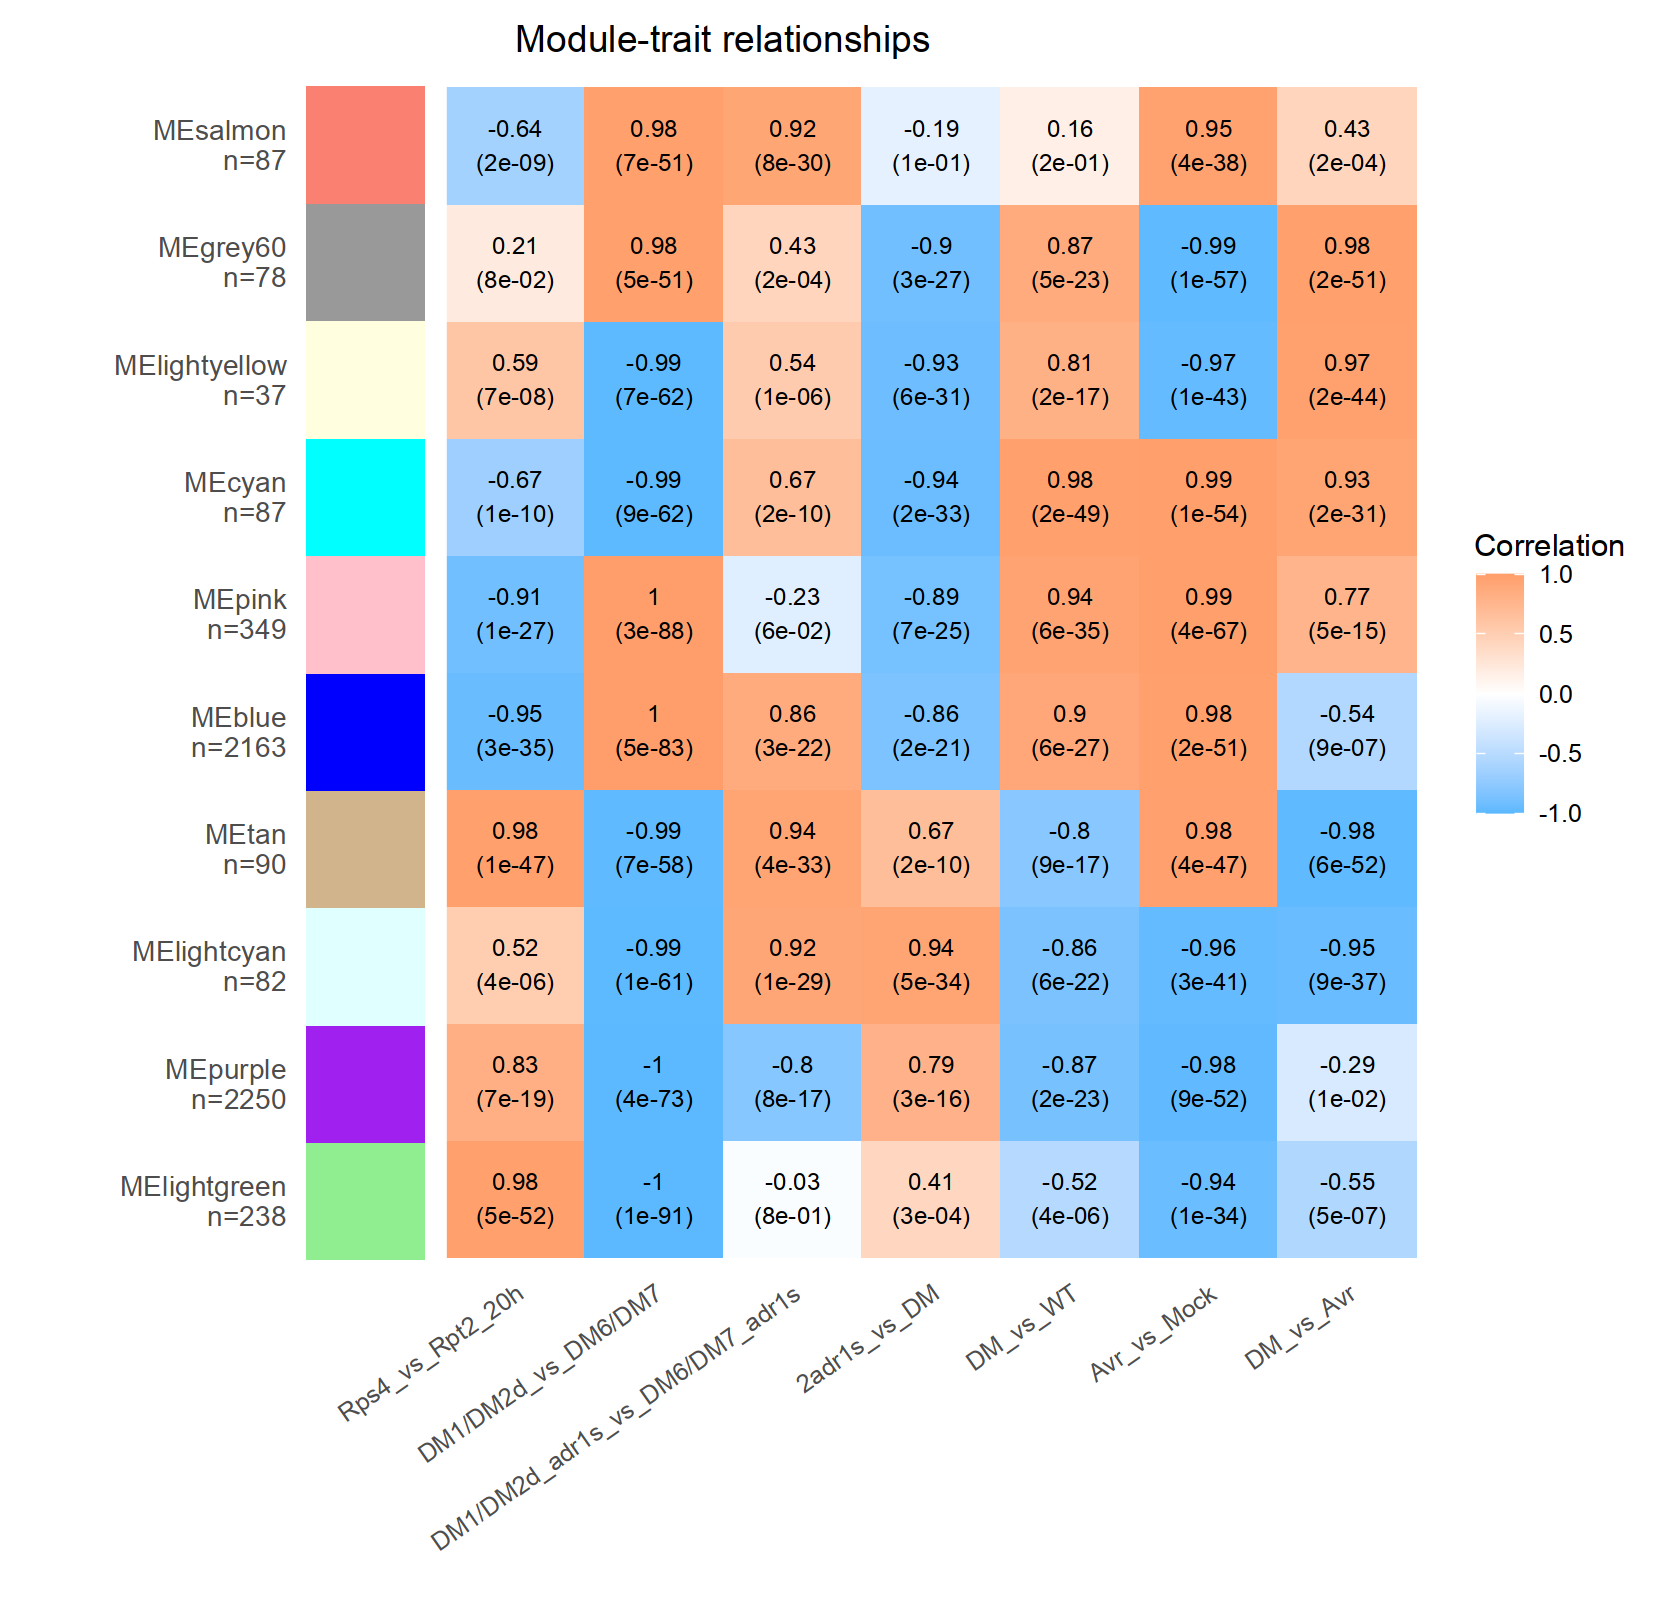

In [71]:
trait_plot_height = 8
trait_plot_width = 8.4
options(repr.plot.width=trait_plot_width, repr.plot.height= trait_plot_height, repr.plot.res = 200)
module_relationship_plot <- ggplot(module_trait_df, aes(x = Trait, y = Module, fill = Correlation)) +
  geom_tile() +
  geom_text(aes(label = paste0(round(Correlation, 2), "\n(", formatC(Pvalue, format = "e", digits = 0), ")")),
            size = 3, color = "black") +
  scale_fill_gradient2(low = "#5CB9FF", mid = "white", high = "#FF9E6A", midpoint = 0, limits = c(-1, 1),
                       guide = guide_colorbar(title = "Correlation", title.position = "top", title.hjust = 0.5)) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 35, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        plot.margin = margin(9, 15, 3, 3, "pt")) +
  labs(x = "", y = "", title = "Module-trait relationships") +
  theme(axis.line  = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        axis.title.y = element_blank()) +
  coord_cartesian(xlim = c(-2, length(unique(module_trait_df$Trait))), clip = 'off') +
  annotation_custom(grob = module_legend_grob2, xmin = -2, xmax = 0.5, ymin = 0.18, ymax = length(unique(module_trait_df$Module)) + 0.74)

module_relationship_plot
module_relationship_plot %>%  ggsave(file = paste0(plots_path, 'relationship', Sys.time(), '.pdf'), 
                    height = trait_plot_height, width = trait_plot_width)


In [72]:
node_data %>% filter(gene %in% c('AT5G49450', 'AT1G23380', 'AT5G65510'))

gene      module
1 AT5G49450 blue

In [73]:
node_data %>% filter(module != 'grey')

gene      module    
1    AT1G71695 purple    
2    AT1G69810 blue      
3    AT1G52200 blue      
4    AT1G71890 lightgreen
5    AT1G80870 purple    
6    AT1G47900 purple    
7    AT1G19715 purple    
8    AT1G07030 blue      
9    AT1G53625 blue      
10   AT1G51440 purple    
11   AT1G80840 blue      
12   AT1G30640 pink      
13   AT1G26440 blue      
14   AT1G22070 salmon    
15   AT1G78180 purple    
16   AT1G06240 purple    
17   AT1G72330 blue      
18   AT1G20840 blue      
19   AT1G52400 tan       
20   AT1G14880 pink      
21   AT1G26650 purple    
22   AT1G34640 purple    
23   AT1G49430 purple    
24   AT1G65820 blue      
25   AT1G35180 purple    
26   AT1G35210 blue      
27   AT1G10410 blue      
28   AT1G10522 purple    
29   AT1G67590 purple    
30   AT1G30530 purple    
⋮    ⋮         ⋮         
5432 AT4G13493 purple    
5433 AT4G04223 grey60    
5434 AT4G12917 lightgreen
5435 AT4G13495 purple    
5436 AT4G36648 blue      
5437 ATMG00030 blue      
5438 ATMG01390 blue      
5439 ATMG00020 blue      
5440 ATCG01020 purple    
5441 ATCG00470 purple    
5442 ATCG00270 purple    
5443 ATCG00490 purple    
5444 ATCG00480 purple    
5445 ATCG00220 purple    
5446 ATCG00530 purple    
5447 ATCG00280 purple    
5448 ATCG00020 purple    
5449 ATCG00540 purple    
5450 ATCG00350 purple    
5451 ATCG00430 purple    
5452 ATCG00300 purple    
5453 ATCG00680 purple    
5454 ATCG00040 purple    
5455 ATCG00340 purple    
5456 ATCG00330 purple    
5457 ATCG00420 purple    
5458 ATCG01210 purple    
5459 ATCG00920 purple    
5460 ATCG01180 purple    
5461 ATCG00950 purple

In [74]:
node_data %>% pull(module) %>%unique

[1] "purple"      "blue"        "lightgreen"  "pink"        "salmon"     
 [6] "tan"         "cyan"        "lightcyan"   "grey60"      "lightyellow"

In [75]:
library('DOSE')
library("clusterProfiler")
library(gprofiler2)

Warning message:
“package ‘DOSE’ was built under R version 4.3.2”
DOSE v3.28.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609


Warning message:
“package ‘clusterProfiler’ was built under R version 4.3.2”
clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter




In [76]:
# Split the data frame into a list of named sublists by module
module_lists <- split(node_data$gene, node_data$module)
module_lists$black %>% length

[1] 0

In [77]:
GOs = gost( module_lists,
      organism = "athaliana", sources = c("GO:BP", "GO:MF", "GO:CC", "KEGG"), multi_query = FALSE, evcodes = TRUE)

In [78]:
# Define the function to process g:Profiler data
process_gprofiler_data <- function(df, include_terms_pattern = NULL, apply_filter = TRUE, cluster_order = NULL) {
  # Select relevant columns from the input dataframe
  gp_mod <- df$result[, c("query", "source", "term_id",
                          "term_name", "p_value", "query_size", 
                          "intersection_size", "term_size", 
                          "effective_domain_size", "intersection")]
  
  # Calculate GeneRatio and BgRatio
  gp_mod$GeneRatio <- paste0(gp_mod$intersection_size, "/", gp_mod$query_size)
  gp_mod$BgRatio <- paste0(gp_mod$term_size, "/", gp_mod$effective_domain_size)
  
  # Rename columns
  names(gp_mod) <- c("Cluster", "Category", "ID", "Description", "p.adjust", 
                     "query_size", "Count", "term_size", "effective_domain_size", 
                     "geneID", "GeneRatio", "BgRatio")
  
  # Replace commas with slashes in geneID column
  gp_mod$geneID <- gsub(",", "/", gp_mod$geneID)
  
  # Apply filter based on include_terms_pattern if apply_filter is TRUE
  if (apply_filter && !is.null(include_terms_pattern)) {
    gp_mod <- gp_mod %>% filter(str_detect(Description, include_terms_pattern))
  }
  
  # Capitalize the first letter of each word in the Description column
  gp_mod$Description <- stringr::str_replace(gp_mod$Description, "^\\w", stringr::str_to_title)
  
  # Factorize the Cluster column based on the input list (cluster_order)
  if (!is.null(cluster_order)) {
    gp_mod$Cluster <- factor(gp_mod$Cluster, levels = cluster_order)
  }

  # Return the modified dataframe
  return(gp_mod)
}

# Usage example:

# Define the terms to include
include_terms <- c('systemic acquired resistance', 'response to salicylic acid', 'response to oxidative stress',
                  'programmed cell death', 'defense response', 'response to hypoxia', 'chitin metabolic process',
                  'aminoglycan metabolic process', 'response to toxic substance', 'hydrogen peroxide catabolic process',
                  'detoxification',
                  'secretory vesicle', 'plasma membrane', 'extracellular region',
                  'tetrapyrrole binding', 'polysaccharide binding', 'peroxidase activity',
                  'Starch and sucrose metabolism', 'Plant-pathogen interaction', 'Phenylpropanoid biosynthesis'
                  )


# Create the include_terms_pattern
include_terms_pattern <- paste0("^(", paste(include_terms, collapse = "|"), ")$")


# Define the list to order Cluster column
# cluster_order <- c("DM10/DM11", "DM1/DM2d", "DM6/DM7", "DM1/DM2d_adr1s", "DM6/DM7_adr1s", "Col-0_adr1s")

# Process the GO_up and GO_down dataframes using the process_gprofiler_data function
GO_result <- process_gprofiler_data(GOs, include_terms_pattern, apply_filter = F )


In [79]:
library(ggh4x)

In [80]:
GO_result %>% arrange(p.adjust)

Cluster     Category ID        
1    purple      GO:CC    GO:0009507
2    purple      GO:CC    GO:0009536
3    blue        GO:BP    GO:0050896
4    blue        GO:BP    GO:0042221
5    purple      GO:CC    GO:0009579
6    blue        GO:BP    GO:0006950
7    purple      GO:CC    GO:0009526
8    purple      GO:CC    GO:0009534
9    purple      GO:CC    GO:0031976
10   purple      GO:CC    GO:0009532
11   purple      GO:CC    GO:0009570
12   purple      GO:CC    GO:0042651
13   purple      GO:CC    GO:0034357
14   purple      GO:CC    GO:0009535
15   purple      GO:CC    GO:0055035
16   blue        GO:BP    GO:0071453
17   blue        GO:BP    GO:0036294
18   blue        GO:BP    GO:0071456
19   blue        GO:BP    GO:0001666
20   blue        GO:BP    GO:0036293
21   blue        GO:BP    GO:0070482
22   purple      GO:CC    GO:0042170
23   purple      GO:BP    GO:0015979
24   purple      GO:CC    GO:0031975
25   purple      GO:CC    GO:0031967
26   purple      GO:CC    GO:0009941
27   purple      GO:CC    GO:0031968
28   purple      GO:CC    GO:0019867
29   blue        GO:BP    GO:0009605
30   blue        GO:BP    GO:0009628
⋮    ⋮           ⋮        ⋮         
1012 purple      GO:BP    GO:0048826
1013 purple      GO:BP    GO:1901463
1014 lightgreen  GO:BP    GO:0010109
1015 lightgreen  GO:BP    GO:0006810
1016 purple      GO:CC    GO:0009501
1017 blue        GO:MF    GO:0004601
1018 salmon      GO:BP    GO:0006858
1019 salmon      GO:BP    GO:0010378
1020 lightgreen  GO:MF    GO:0016872
1021 cyan        GO:MF    GO:0032553
1022 purple      GO:BP    GO:0044238
1023 purple      GO:BP    GO:0009769
1024 purple      GO:BP    GO:0015976
1025 blue        GO:BP    GO:0031408
1026 purple      GO:MF    GO:0046527
1027 cyan        GO:BP    GO:0007165
1028 salmon      GO:BP    GO:0000122
1029 lightgreen  GO:BP    GO:0008610
1030 lightyellow GO:BP    GO:0014070
1031 tan         GO:CC    GO:0005777
1032 tan         GO:CC    GO:0042579
1033 blue        GO:MF    GO:0016878
1034 purple      GO:BP    GO:0065008
1035 blue        GO:CC    GO:0031410
1036 purple      GO:BP    GO:0006793
1037 cyan        GO:MF    GO:0097367
1038 salmon      GO:BP    GO:0090304
1039 tan         GO:BP    GO:0010683
1040 blue        GO:BP    GO:0002221
1041 lightgreen  KEGG     KEGG:00941
     Description                                               p.adjust     
1    Chloroplast                                               1.522087e-186
2    Plastid                                                   7.596566e-165
3    Response to stimulus                                      4.734046e-143
4    Response to chemical                                      1.080297e-133
5    Thylakoid                                                 2.927814e-133
6    Response to stress                                        1.488540e-128
7    Plastid envelope                                          7.354593e-127
8    Chloroplast thylakoid                                     8.060303e-123
9    Plastid thylakoid                                         2.652452e-122
10   Plastid stroma                                            1.413112e-108
11   Chloroplast stroma                                        3.971742e-108
12   Thylakoid membrane                                         1.749119e-97
13   Photosynthetic membrane                                    3.076071e-97
14   Chloroplast thylakoid membrane                             5.322742e-95
15   Plastid thylakoid membrane                                 1.666552e-94
16   Cellular response to oxygen levels                         4.659269e-93
17   Cellular response to decreased oxygen levels               4.659269e-93
18   Cellular response to hypoxia                               1.742611e-92
19   Response to hypoxia                                        1.022549e-89
20   Response to decreased oxygen levels                        1.118852e-89
21   Response to oxygen levels                                  2.276096e-89
22   Plastid memb

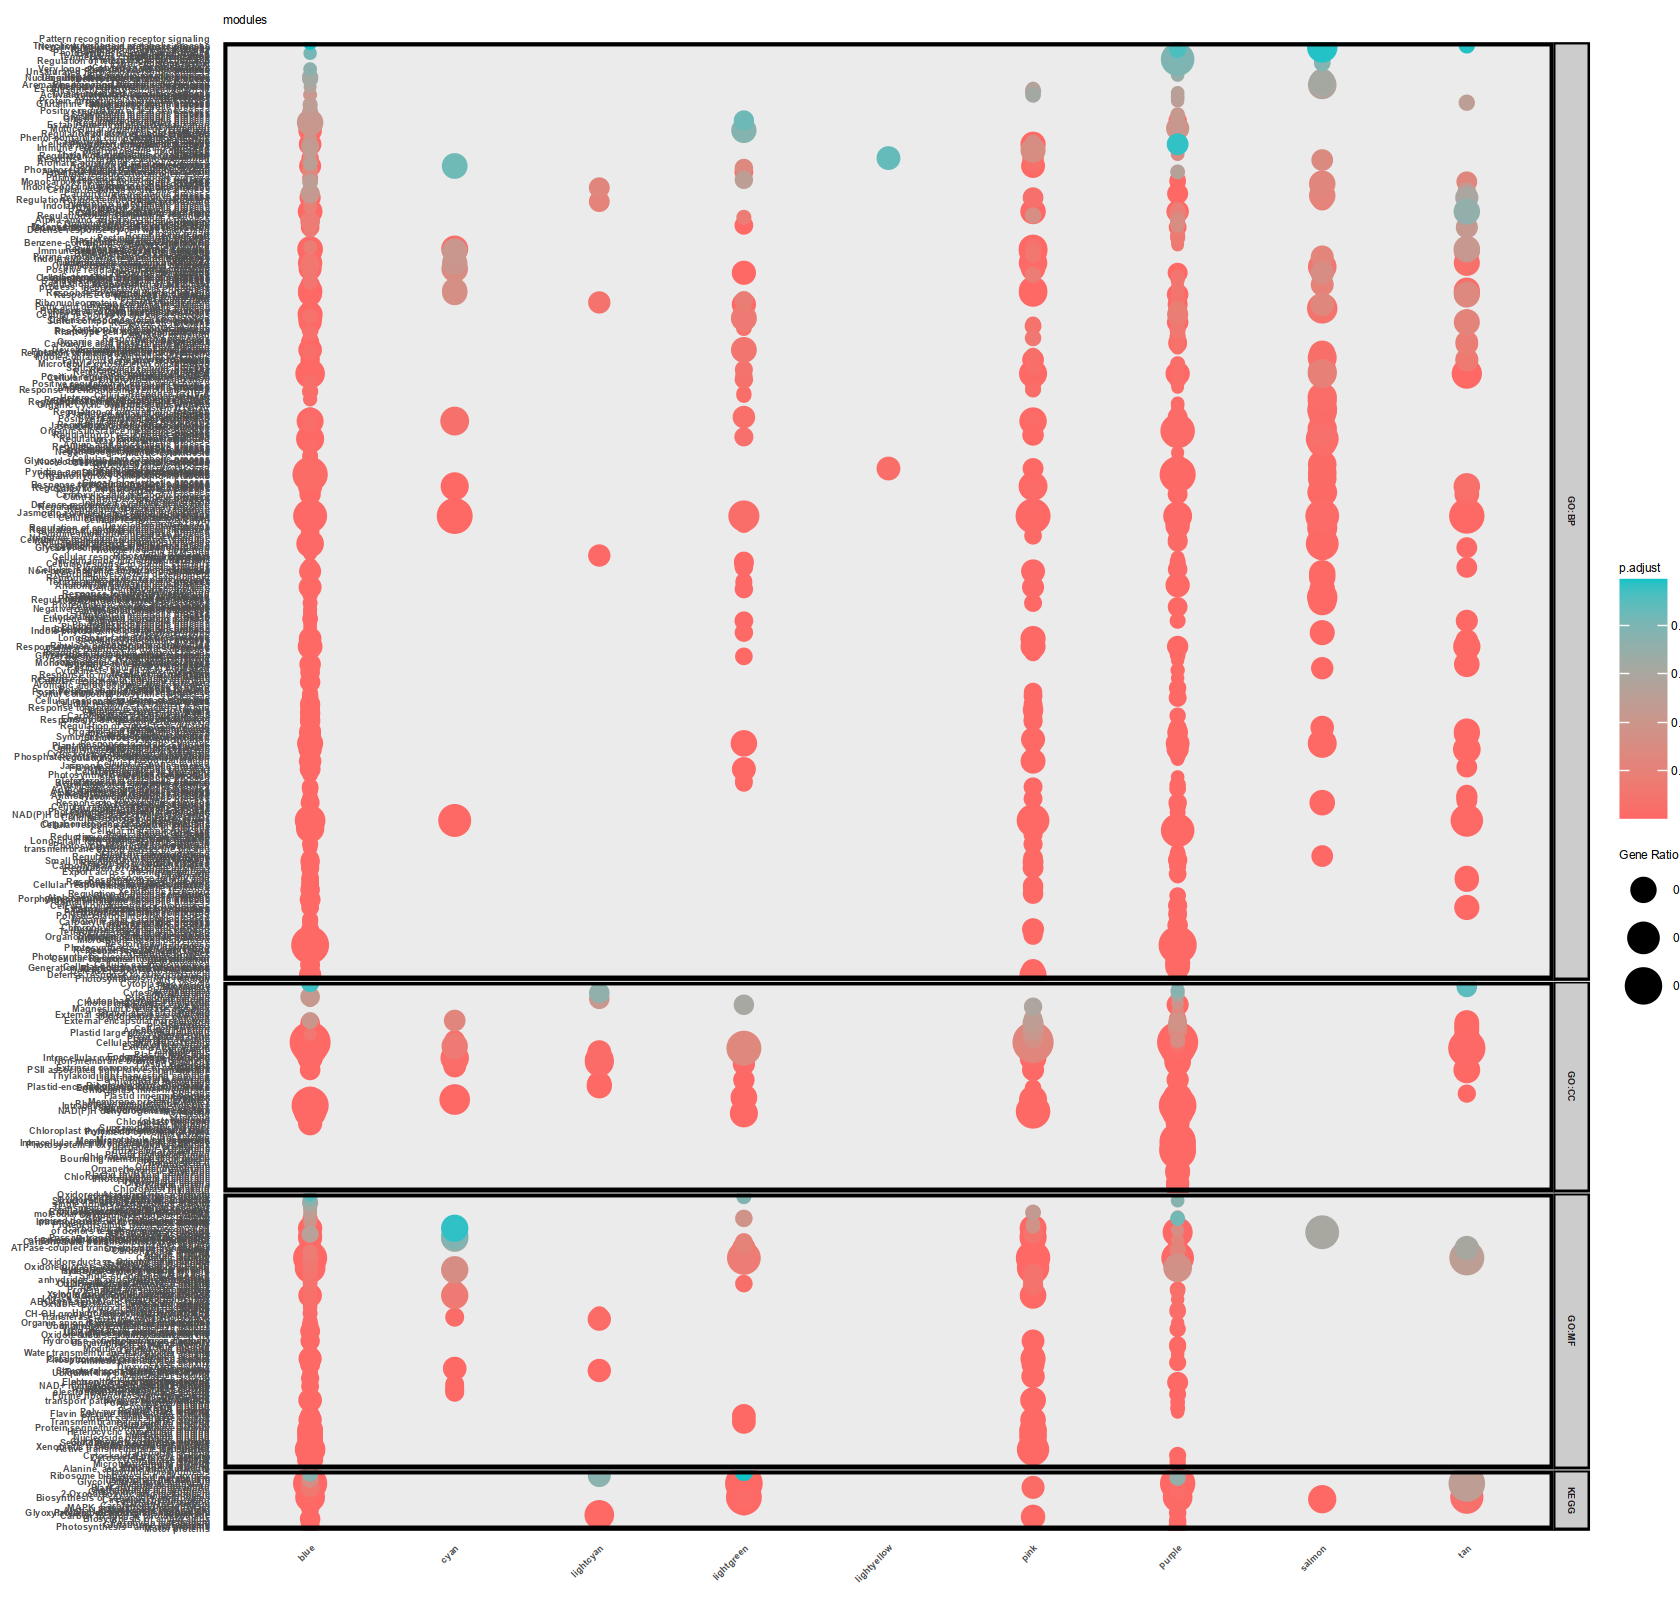

In [81]:
# Function to create a customized dot plot
customize_dotplot <- function(data,
                              description_width = 40,
                              low_color = "#fe6865",
                              high_color = "#0fc3c7",
                              text_size = 10,
                              panel_spacing_y = 0.05,
                              dodge_labels = FALSE,
                              plot_title = "Customized Dot Plot") {
  
  # Wrap the Description text to a fixed width
  data$Description <- str_wrap(data$Description, width = description_width)
  
  # Calculate the proportions of unique Descriptions for each Category
  category_proportions <- data %>%
    group_by(Category) %>%
    summarise(n_unique_descriptions = n_distinct(Description)) %>%
    mutate(proportion = n_unique_descriptions / sum(n_unique_descriptions)) %>%
    pull(proportion)
    
  # Create the customized dot plot
  go_plot <- ggplot(data, aes(x = Cluster, y = reorder(Description, `p.adjust`), size = Count/query_size, color = `p.adjust`)) +
    geom_point() +
    scale_color_gradient(low = low_color, high = high_color) +
    facet_grid(Category ~ . , scales = "free_y",
               labeller = label_wrap_gen(width = description_width, multi_line = T)) +
    labs(title = plot_title,
         x = NULL, # Remove x-axis title
         y = NULL, # Remove y-axis title
         size = "Gene Ratio",
         color = "p.adjust") +
    theme_minimal() +
    theme(
      text = element_text(size = text_size, color = "black"),
      plot.title = element_text(size = text_size, color = "black"), # Set plot title font size
      legend.text = element_text(size = text_size, color = "black"), # Set legend font size
      strip.background = element_rect(fill = "grey80"),
      panel.border = element_rect(colour = "black", fill = NA, linewidth = 1),
      panel.spacing.y = unit(panel_spacing_y, "lines"), # Set space between facets
      legend.margin = margin(0, -10, 0, 0), # Reduced space between legend and plot
      axis.text.y = element_text(face = "bold"), # Bold Description
      axis.text.x = element_text(face = "bold", angle = ifelse(dodge_labels, 45, 0), hjust = ifelse(dodge_labels, 1, 0.5), vjust = ifelse(dodge_labels, 1, 0.5)), # Bold Cluster with optional dodging
      strip.text.y = element_text(face = "bold") # Bold facet name
    ) + 
    guides(size = guide_legend(order = 0),
           color = guide_colourbar(order = 1)) +
    force_panelsizes(rows = category_proportions)
  
  return(go_plot)
}

# Call the function with the data object and dodge_labels set to TRUE
go_plot <- GO_result %>% customize_dotplot(plot_title = 'modules', text_size = 4, dodge_labels = TRUE)
# go_plot
go_plot


In [82]:
# Call the function with the data object and dodge_labels set to TRUE
go_plot <- GO_result %>% customize_dotplot(plot_title = 'modules', text_size = 4, dodge_labels = TRUE)
# go_plot

In [83]:
go_plot_list <- list()
for (i in GO_result %>% pull(Cluster) %>% unique) {
   GO_result %>% filter(Cluster == i) %>% customize_dotplot(plot_title = 'modules', text_size = 4, dodge_labels = TRUE)
}

In [84]:
# Create an empty list for storing the plots
go_plot_list <- list()

# Iterate through each unique value in the "cluster" column
for (i in unique(GO_result$Cluster)) {
  # Filter the data for the specific cluster value
  cluster_data <- GO_result %>% filter(Cluster == i)
  
  # Customize the dot plot and store it in a variable
  plot <- customize_dotplot(cluster_data, plot_title = 'modules', text_size = 8, dodge_labels = TRUE)
  
  # Append the plot to the go_plot_list
  go_plot_list[[paste0("Cluster_", i)]] <- plot
}


In [85]:
# Load necessary libraries
library(gridExtra)
library(grid)
# Arrange the plots from go_plot_list in a grid with the specified dimensions
combined_plot <- arrangeGrob(grobs = go_plot_list, ncol = 2, width =8.4)

# Display the combined plot
# grid.draw(combined_plot)
combined_plot %>% ggsave(file = paste0(plots_path, 'GO_', Sys.time(), '.pdf'), height = 40, width = 8)

In [86]:
node_data %>% mutate(module = paste0('ME', module )) %>% mutate(module = factor(module, levels = rownames(moduleTraitCor))) %>% filter(module == 'MEsalmon') %>% left_join(map_id_name, by= c('gene' = 'gene_id')) %>% pull(gene_name)

[1] "TGA3"      "AT1G74250" "BBX13"     "AT1G70420" "PP2-A12"   "AT1G15870"
 [7] "AT1G19370" "AT1G26580" "GI"        "DJC53"     "AT1G11210" "RCF1"     
[13] "ATHMAD1"   "DYL1"      "LZF1"      "AT1G21680" "AT1G14640" "ALDH5F1"  
[19] "CYCT1;3"   "IAN9"      "UGT80B1"   "HSFA8"     "FKF1"      "ABF1"     
[25] "AT1G17665" "PRR5"      "ACA8"      "AT5G01750" "HSFA3"     "BET9"     
[31] "AT5G18540" "BBX8"      "TOC1"      "AT5G62910" "AT5G50450" "AT5G43440"
[37] "AT5G39410" "MYBS2"     "DJC76"     "PRR3"      "COR27"     "AT5G23575"
[43] "JMJD5"     "AT3G56720" "HUP26"     "PCL1"      "DLK2"      "MAZ"      
[49] "RCI2A"     "ATVIP1"    "CCL"       "ATHMP23"   "AT3G26580" "AT3G47160"
[55] "SCPL49"    "COL9"      "ATGLSA1"   "AT3G54366" "TRM27"     "ELF4"     
[61] "XBAT31"    "TRM4B"     "GRP2B"     "AT2G25730" "ATC3H17"   "ERD7"     
[67] "BAG6"      "TAG1"      "LRX10"     "MEE14"     "BAT1"      "RIBA2"    
[73] "DRM2"      "AT2G21130" "ELF3"      "GRP7"      "AT2G28360" "AT4G14230"
[79] "AT4G17140" "COR28"     "RS40"      "CCR1"      "ACR7"      "AT4G05150"
[85] "GGCT2;2"   "AT4G16146" "OZF2"

In [87]:
formula_GO_BP <- compareCluster( gene ~ module ,data = node_data,# %>% as.data.frame, 
                              OrgDb = "org.At.tair.db", 
                              fun = "enrichGO", ont="BP",
                              keyType="TAIR")

simplified_GO_BP <- simplify(formula_GO_BP, 
                       cutoff=0.5, # smaller,fewer category  0.4
                       by="p.adjust", select_fun = min,
  measure = "Wang",)

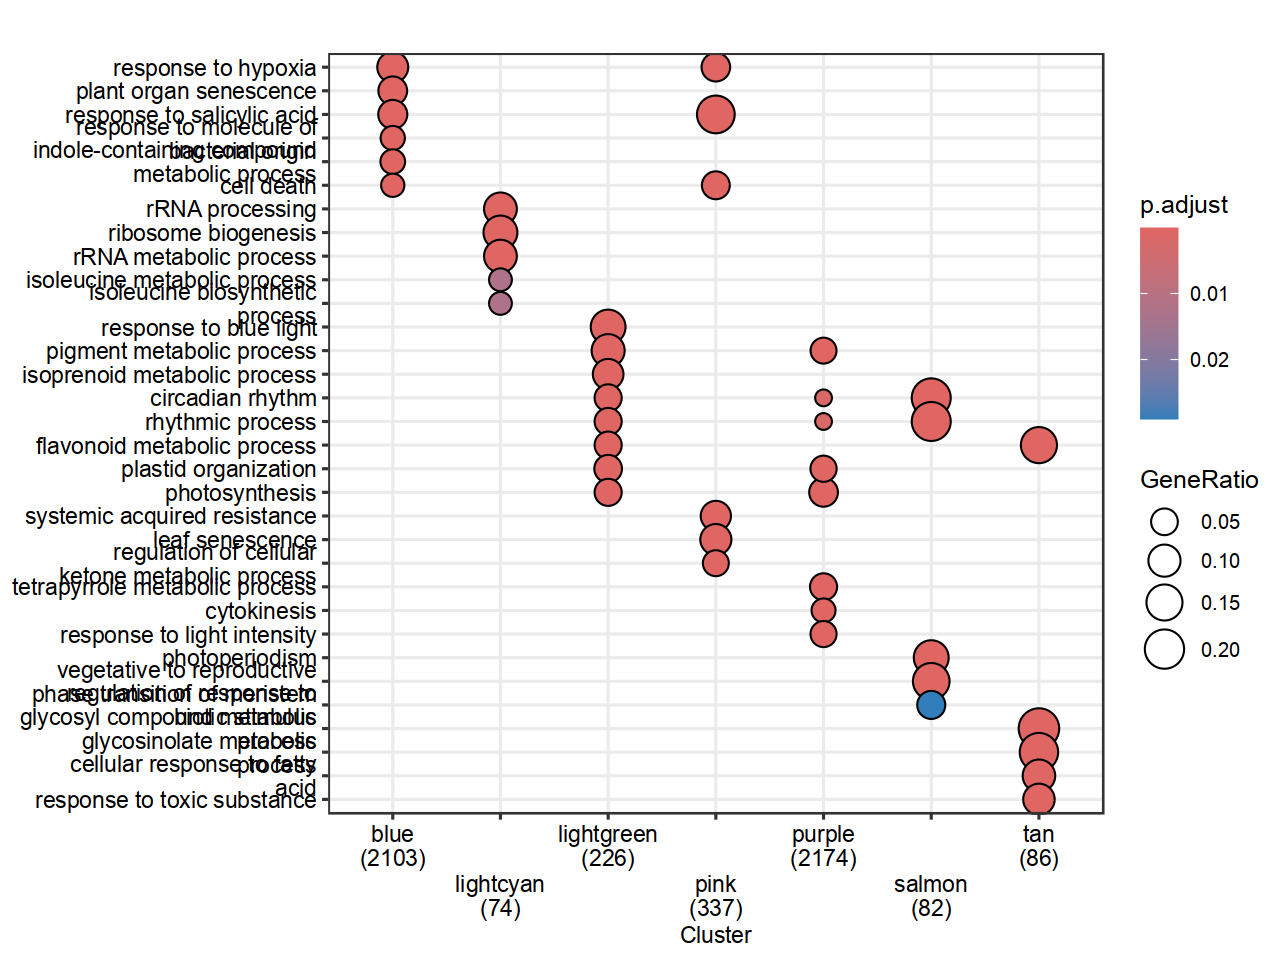

In [88]:
options(repr.plot.width=8, repr.plot.height=6, repr.plot.res = 160)

#somehow the levels of module is lost, level it again
GO_plot <- dotplot(simplified_GO_BP,
                   font.size = 10) + scale_x_discrete(guide = guide_axis(n.dodge = 2)) #+ theme_Publication()
GO_plot %>% ggsave(file = paste0(plots_path, "wgcna_GO_plot_2.pdf"), width=8, height=8)
GO_plot

# heatmap

In [89]:
Res_combined <- readRDS('./Rdata/Res_combined.rds')
Res_combined

AGI       log2FC      source        
1      AT1G30814  5.18459620 DM6/DM7       
2      AT1G78930  0.01991274 DM6/DM7       
3      AT1G71695 -2.30890364 DM6/DM7       
4      AT1G58983 -0.17951020 DM6/DM7       
5      AT1G12980  2.27948272 DM6/DM7       
6      AT1G56250  0.77412597 DM6/DM7       
7      AT1G66852  0.00000000 DM6/DM7       
8      AT1G69810  2.76176191 DM6/DM7       
9      AT1G72450 -0.41945456 DM6/DM7       
10     AT1G76280 -0.42485352 DM6/DM7       
11     AT1G65630 -2.65909162 DM6/DM7       
12     AT1G71390  4.94242971 DM6/DM7       
13     AT1G15210  0.15281775 DM6/DM7       
14     AT1G15250 -0.25189140 DM6/DM7       
15     AT1G79700 -0.10009903 DM6/DM7       
16     AT1G73360 -3.95462558 DM6/DM7       
17     AT1G16360 -1.35935929 DM6/DM7       
18     AT1G10225 -0.59364808 DM6/DM7       
19     AT1G26670  0.60329926 DM6/DM7       
20     AT1G52200  3.54791726 DM6/DM7       
21     AT1G57800  0.00000000 DM6/DM7       
22     AT1G69460  0.23281495 DM6/DM7       
23     AT1G04310 -0.53626527 DM6/DM7       
24     AT1G08080 -3.34879101 DM6/DM7       
25     AT1G75550 -3.24048831 DM6/DM7       
26     AT1G71890  0.19682873 DM6/DM7       
27     AT1G05430  0.20292319 DM6/DM7       
28     AT1G80870  0.69900541 DM6/DM7       
29     AT1G75310  0.19755597 DM6/DM7       
30     AT1G02010 -0.93473861 DM6/DM7       
⋮      ⋮         ⋮           ⋮             
311701 AT3G44460 -14.49592   Col-0_adr1s   
311702 ATMG01275 -14.57193   Col-0_adr1s   
311703 AT3G01313 -14.73614   Col-0_adr1s   
311704 ATMG00290 -15.22105   Col-0_adr1s   
311705 ATCG00905 -15.32369   Col-0_adr1s   
311706 ATCG00250 -15.36171   Col-0_adr1s   
311707 AT3G04975 -15.46356   Col-0_adr1s   
311708 AT3G19350 -15.60237   Col-0_adr1s   
311709 AT5G44310 -15.79518   Col-0_adr1s   
311710 AT3G13433 -15.79653   Col-0_adr1s   
311711 ATMG00720 -16.23952   Col-0_adr1s   
311712 AT2G08820 -16.34987   Col-0_adr1s   
311713 AT2G42560 -16.45635   DM6/DM7_adr1s 
311714 AT5G22470 -17.92847   DM6/DM7_adr1s 
311715 AT3G03260 -17.95694   Col-0_adr1s   
311716 AT1G71000 -18.31402   Col-0_adr1s   
311717 AT3G17520 -18.57301   Col-0_adr1s   
311718 AT3G25240 -18.66534   Col-0_adr1s   
311719 AT2G17680 -18.78335   DM6/DM7_adr1s 
311720 AT4G27140 -19.96459   DM6/DM7_adr1s 
311721 AT3G24750 -20.62148   Col-0_adr1s   
311722 AT1G12610 -20.62553   DM1/DM2d_adr1s
311723 AT1G52690 -20.89255   Col-0_adr1s   
311724 AT3G11480 -22.09972   Col-0_adr1s   
311725 AT4G27150 -22.10308   Col-0_adr1s   
311726 AT5G44310 -25.53899   DM6/DM7_adr1s 
311727 AT4G21020 -30.52377   DM1/DM2d_adr1s
311728 AT1G04560 -31.02019   DM1/DM2d_adr1s
311729 AT1G72100 -41.98945   DM1/DM2d_adr1s
311730 AT1G75470 -44.02230   DM1/DM2d_adr1s

In [90]:
node_data 

gene      module    
1    AT1G71695 purple    
2    AT1G69810 blue      
3    AT1G52200 blue      
4    AT1G71890 lightgreen
5    AT1G80870 purple    
6    AT1G47900 purple    
7    AT1G19715 purple    
8    AT1G07030 blue      
9    AT1G53625 blue      
10   AT1G51440 purple    
11   AT1G80840 blue      
12   AT1G30640 pink      
13   AT1G26440 blue      
14   AT1G22070 salmon    
15   AT1G78180 purple    
16   AT1G06240 purple    
17   AT1G72330 blue      
18   AT1G20840 blue      
19   AT1G52400 tan       
20   AT1G14880 pink      
21   AT1G26650 purple    
22   AT1G34640 purple    
23   AT1G49430 purple    
24   AT1G65820 blue      
25   AT1G35180 purple    
26   AT1G35210 blue      
27   AT1G10410 blue      
28   AT1G10522 purple    
29   AT1G67590 purple    
30   AT1G30530 purple    
⋮    ⋮         ⋮         
5432 AT4G13493 purple    
5433 AT4G04223 grey60    
5434 AT4G12917 lightgreen
5435 AT4G13495 purple    
5436 AT4G36648 blue      
5437 ATMG00030 blue      
5438 ATMG01390 blue      
5439 ATMG00020 blue      
5440 ATCG01020 purple    
5441 ATCG00470 purple    
5442 ATCG00270 purple    
5443 ATCG00490 purple    
5444 ATCG00480 purple    
5445 ATCG00220 purple    
5446 ATCG00530 purple    
5447 ATCG00280 purple    
5448 ATCG00020 purple    
5449 ATCG00540 purple    
5450 ATCG00350 purple    
5451 ATCG00430 purple    
5452 ATCG00300 purple    
5453 ATCG00680 purple    
5454 ATCG00040 purple    
5455 ATCG00340 purple    
5456 ATCG00330 purple    
5457 ATCG00420 purple    
5458 ATCG01210 purple    
5459 ATCG00920 purple    
5460 ATCG01180 purple    
5461 ATCG00950 purple

In [91]:
Res_combined <- Res_combined  %>% right_join(node_data, by= c('AGI' = 'gene')) %>% 
    mutate(module = paste0('ME', module )) %>% mutate(module = factor(module, levels = rownames(moduleTraitCor) %>% rev))

In [92]:
Res_combined 

AGI       log2FC      source        module      
1     AT1G71695 -2.30890364 DM6/DM7       MEpurple    
2     AT1G69810  2.76176191 DM6/DM7       MEblue      
3     AT1G52200  3.54791726 DM6/DM7       MEblue      
4     AT1G71890  0.19682873 DM6/DM7       MElightgreen
5     AT1G80870  0.69900541 DM6/DM7       MEpurple    
6     AT1G47900 -1.49346350 DM6/DM7       MEpurple    
7     AT1G19715 -1.22585925 DM6/DM7       MEpurple    
8     AT1G07030  0.03791134 DM6/DM7       MEblue      
9     AT1G53625  4.26339023 DM6/DM7       MEblue      
10    AT1G51440 -6.11859794 DM6/DM7       MEpurple    
11    AT1G80840  1.20844107 DM6/DM7       MEblue      
12    AT1G30640  1.53798190 DM6/DM7       MEpink      
13    AT1G26440  1.89857257 DM6/DM7       MEblue      
14    AT1G22070  1.20696621 DM6/DM7       MEsalmon    
15    AT1G78180 -1.83594149 DM6/DM7       MEpurple    
16    AT1G06240 -1.03998866 DM6/DM7       MEpurple    
17    AT1G72330  1.77417710 DM6/DM7       MEblue      
18    AT1G20840  0.67398899 DM6/DM7       MEblue      
19    AT1G52400 -3.57971967 DM6/DM7       MEtan       
20    AT1G14880  6.59290711 DM6/DM7       MEpink      
21    AT1G26650 -1.21559492 DM6/DM7       MEpurple    
22    AT1G34640 -0.47185972 DM6/DM7       MEpurple    
23    AT1G49430 -1.45947420 DM6/DM7       MEpurple    
24    AT1G65820  1.32394518 DM6/DM7       MEblue      
25    AT1G35180 -3.14125233 DM6/DM7       MEpurple    
26    AT1G35210  1.13781105 DM6/DM7       MEblue      
27    AT1G10410  1.91326691 DM6/DM7       MEblue      
28    AT1G10522 -1.87406160 DM6/DM7       MEpurple    
29    AT1G67590 -1.38728742 DM6/DM7       MEpurple    
30    AT1G30530 -3.00984370 DM6/DM7       MEpurple    
⋮     ⋮         ⋮           ⋮             ⋮           
65503 AT2G30770  -8.390013  Col-0_adr1s   MEblue      
65504 AT5G62360  -8.507689  Col-0_adr1s   MEpurple    
65505 ATCG00420  -8.567115  Col-0_adr1s   MEpurple    
65506 AT1G33730  -8.601927  Col-0_adr1s   MEpink      
65507 AT1G19530  -8.622000  Col-0_adr1s   MEblue      
65508 ATCG00040  -8.900239  Col-0_adr1s   MEpurple    
65509 ATCG01020  -9.037233  Col-0_adr1s   MEpurple    
65510 ATCG00220  -9.061366  Col-0_adr1s   MEpurple    
65511 AT5G44990  -9.093611  Col-0_adr1s   MEblue      
65512 AT2G38465  -9.143967  Col-0_adr1s   MEblue      
65513 AT1G66570  -9.168981  Col-0_adr1s   MEblue      
65514 AT2G45130  -9.334702  Col-0_adr1s   MEblue      
65515 AT3G21500  -9.341464  Col-0_adr1s   MEblue      
65516 AT2G40340  -9.394898  Col-0_adr1s   MEblue      
65517 AT1G56300  -9.422499  Col-0_adr1s   MEsalmon    
65518 AT3G01345  -9.456143  DM6/DM7_adr1s MElightcyan 
65519 AT1G71520  -9.659263  Col-0_adr1s   MEblue      
65520 AT4G33980  -9.725253  Col-0_adr1s   MEsalmon    
65521 ATCG00430  -9.749625  Col-0_adr1s   MEpurple    
65522 AT5G24470  -9.883106  Col-0_adr1s   MEsalmon    
65523 AT2G13810 -10.079207  Col-0_adr1s   MEblue      
65524 AT2G33830 -10.683295  Col-0_adr1s   MEsalmon    
65525 AT4G24000 -10.779614  Col-0_adr1s   MEblue      
65526 AT5G37490 -11.159898  Col-0_adr1s   MEblue      
65527 AT1G68050 -11.681133  Col-0_adr1s   MEsalmon    
65528 AT3G49540 -11.796092  Col-0_adr1s   MEblue      
65529 AT5G42900 -13.065809  Col-0_adr1s   MEsalmon    
65530 AT3G13433 -15.796530  Col-0_adr1s   MEpink      
65531 AT1G71000 -18.314017  Col-0_adr1s   MEblue      
65532 AT3G25240 -18.665337  Col-0_adr1s   MEblue

In [93]:
Res_combined <- Res_combined %>% mutate(source = factor(source, levels = c('AvrRpt2-6h', 'AvrRpt2-12h', 'AvrRpt2-20h',
        'AvrRps4-6h', 'AvrRps4-12h', 'AvrRps4-20h',   'DM10/DM11',  'DM1/DM2d',  'DM6/DM7',
        'DM1/DM2d_adr1s', 'DM6/DM7_adr1s', 'Col-0_adr1s')))

In [94]:
module_n <- node_data %>%  mutate(module = paste0('ME', module )) %>% 
    mutate(module = factor(module, levels = rownames(moduleTraitCor) %>% rev))%>% 
    group_by(module) %>% summarise(n =n())
module_list <- split(module_n$n, module_n$module)
names(module_list) <- module_n$module
module_list

$MEsalmon
[1] 87

$MEgrey60
[1] 78

$MElightyellow
[1] 37

$MEcyan
[1] 87

$MEpink
[1] 349

$MEblue
[1] 2163

$MEtan
[1] 90

$MElightcyan
[1] 82

$MEpurple
[1] 2250

$MElightgreen
[1] 238

In [95]:
rownames(moduleTraitCor)

[1] "MElightgreen"  "MEpurple"      "MElightcyan"   "MEtan"        
 [5] "MEblue"        "MEpink"        "MEcyan"        "MElightyellow"
 [9] "MEgrey60"      "MEsalmon"

In [96]:
module_trait_n

Module        n    Module_n           
1  MElightgreen   238 MElightgreen\nn=238
2  MEpurple      2250 MEpurple\nn=2250   
3  MElightcyan     82 MElightcyan\nn=82  
4  MEtan           90 MEtan\nn=90        
5  MEblue        2163 MEblue\nn=2163     
6  MEpink         349 MEpink\nn=349      
7  MEcyan          87 MEcyan\nn=87       
8  MElightyellow   37 MElightyellow\nn=37
9  MEgrey60        78 MEgrey60\nn=78     
10 MEsalmon        87 MEsalmon\nn=87

In [97]:
Res_combined <- Res_combined %>% left_join(module_trait_n, by = c('module' = 'Module') )

In [98]:
Res_combined %>% mutate(Module_n = Module_n %>% str_replace('\n', ' '))

AGI       log2FC      source        module       n    Module_n          
1     AT1G71695 -2.30890364 DM6/DM7       MEpurple     2250 MEpurple n=2250   
2     AT1G69810  2.76176191 DM6/DM7       MEblue       2163 MEblue n=2163     
3     AT1G52200  3.54791726 DM6/DM7       MEblue       2163 MEblue n=2163     
4     AT1G71890  0.19682873 DM6/DM7       MElightgreen  238 MElightgreen n=238
5     AT1G80870  0.69900541 DM6/DM7       MEpurple     2250 MEpurple n=2250   
6     AT1G47900 -1.49346350 DM6/DM7       MEpurple     2250 MEpurple n=2250   
7     AT1G19715 -1.22585925 DM6/DM7       MEpurple     2250 MEpurple n=2250   
8     AT1G07030  0.03791134 DM6/DM7       MEblue       2163 MEblue n=2163     
9     AT1G53625  4.26339023 DM6/DM7       MEblue       2163 MEblue n=2163     
10    AT1G51440 -6.11859794 DM6/DM7       MEpurple     2250 MEpurple n=2250   
11    AT1G80840  1.20844107 DM6/DM7       MEblue       2163 MEblue n=2163     
12    AT1G30640  1.53798190 DM6/DM7       MEpink        349 MEpink n=349      
13    AT1G26440  1.89857257 DM6/DM7       MEblue       2163 MEblue n=2163     
14    AT1G22070  1.20696621 DM6/DM7       MEsalmon       87 MEsalmon n=87     
15    AT1G78180 -1.83594149 DM6/DM7       MEpurple     2250 MEpurple n=2250   
16    AT1G06240 -1.03998866 DM6/DM7       MEpurple     2250 MEpurple n=2250   
17    AT1G72330  1.77417710 DM6/DM7       MEblue       2163 MEblue n=2163     
18    AT1G20840  0.67398899 DM6/DM7       MEblue       2163 MEblue n=2163     
19    AT1G52400 -3.57971967 DM6/DM7       MEtan          90 MEtan n=90        
20    AT1G14880  6.59290711 DM6/DM7       MEpink        349 MEpink n=349      
21    AT1G26650 -1.21559492 DM6/DM7       MEpurple     2250 MEpurple n=2250   
22    AT1G34640 -0.47185972 DM6/DM7       MEpurple     2250 MEpurple n=2250   
23    AT1G49430 -1.45947420 DM6/DM7       MEpurple     2250 MEpurple n=2250   
24    AT1G65820  1.32394518 DM6/DM7       MEblue       2163 MEblue n=2163     
25    AT1G35180 -3.14125233 DM6/DM7       MEpurple     2250 MEpurple n=2250   
26    AT1G35210  1.13781105 DM6/DM7       MEblue       2163 MEblue n=2163     
27    AT1G10410  1.91326691 DM6/DM7       MEblue       2163 MEblue n=2163     
28    AT1G10522 -1.87406160 DM6/DM7       MEpurple     2250 MEpurple n=2250   
29    AT1G67590 -1.38728742 DM6/DM7       MEpurple     2250 MEpurple n=2250   
30    AT1G30530 -3.00984370 DM6/DM7       MEpurple     2250 MEpurple n=2250   
⋮     ⋮         ⋮           ⋮             ⋮            ⋮    ⋮                 
65503 AT2G30770  -8.390013  Col-0_adr1s   MEblue       2163 MEblue n=2163     
65504 AT5G62360  -8.507689  Col-0_adr1s   MEpurple     2250 MEpurple n=2250   
65505 ATCG00420  -8.567115  Col-0_adr1s   MEpurple     2250 MEpurple n=2250   
65506 AT1G33730  -8.601927  Col-0_adr1s   MEpink        349 MEpink n=349      
65507 AT1G19530  -8.622000  Col-0_adr1s   MEblue       2163 MEblue n=2163     
65508 ATCG00040  -8.900239  Col-0_adr1s   MEpurple     2250 MEpurple n=2250   
65509 ATCG01020  -9.037233  Col-0_adr1s   MEpurple     2250 MEpurple n=2250   
65510 ATCG00220  -9.061366  Col-0_adr1s   MEpurple     2250 MEpurple n=2250   
65511 AT5G44990  -9.093611  Col-0_adr1s   MEblue       2163 MEblue n=2163     
65512 AT2G38465  -9.143967  Col-0_adr1s   MEblue       2163 MEblue n=2163     
65513 AT1G66570  -9.168981  Col-0_adr1s   MEblue       2163 MEblue n=2163     
65514 AT2G45130  -9.334702  Col-0_adr1s   MEblue       2163 MEblue n=2163     
65515 AT3G21500  -9.341464  Col-0_adr1s   MEblue       2163 MEblue n=2163     
65516 AT2G40340  -9.394898  Col-0_adr1s   MEblue       2163 MEblue n=2163     
65517 AT1G56300  -9.422499  Col-0_adr1s   MEsalmon       87 MEsalmon n=87     
65518 AT3G01345  -9.456143  DM6/DM7_adr1s MElightcyan    82 MElightcyan n=82  
65519 AT1G71520  -9.659263  Col-0_adr1s   MEblue       2163 MEblue n=2163     
65520 AT4G33980  -9.725253  Col-0_adr1s   MEsalmon       87 MEsalmon n=87     
65521 ATCG00430  -9.749625  Col-0_adr1s   MEpurple     2

In [99]:
Res_combined %>% pull(source) %>% unique

[1] DM6/DM7        DM1/DM2d       DM10/DM11      AvrRpt2-6h     AvrRpt2-12h   
 [6] AvrRpt2-20h    AvrRps4-6h     AvrRps4-12h    AvrRps4-20h    DM1/DM2d_adr1s
[11] Col-0_adr1s    DM6/DM7_adr1s 
12 Levels: AvrRpt2-6h AvrRpt2-12h AvrRpt2-20h AvrRps4-6h ... Col-0_adr1s

In [100]:
#factor column Module_n as module #
Res_combined <- Res_combined %>%
  arrange(module) %>%
  mutate(Module_n = forcats::fct_inorder(as.character(Module_n)))

In [101]:
Res_combined %>% pull(module) %>% unique

[1] MEsalmon      MEgrey60      MElightyellow MEcyan        MEpink       
 [6] MEblue        MEtan         MElightcyan   MEpurple      MElightgreen 
10 Levels: MEsalmon MEgrey60 MElightyellow MEcyan MEpink MEblue ... MElightgreen

In [102]:
module_colors <- list(
  "MEmidnightblue" = "#00009C",  # Substitute with your desired colors
  "MEdarkgreen" = "#006400",
  "MEtan" = "#D2B48C",
  "MEsalmon" = "#FA8072",
  "MEgreenyellow" = "#ADFF2F",
  "MEdarkred" = "#8B0000",
  "MEcyan" = "#00FFFF",
  "MEdarkturquoise" = "#00CED1",
  "MEpurple" = "#800080",
  "MEblue" = "#0000FF"
)


In [103]:
Res_combined %>% saveRDS('./Rdata/Res_combined_WGCNA.rds')

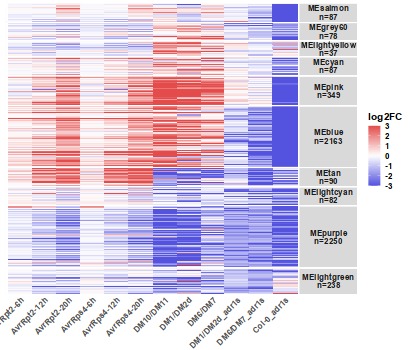

In [104]:
width_ = 8.2
height_ = 7
options(repr.plot.width= width_ , repr.plot.height= height_ , repr.plot.res = 50)

library(RColorBrewer)
plot <- Res_combined %>% ggplot(aes(x = source, y = AGI, fill = log2FC)) +
    geom_tile() +
    scale_fill_gradientn(
        colors = colorRampPalette(rev(c( '#e34c4b', 'white', '#5453e0' )))(30),
        limits = c(-3, 3),
        guide = guide_colorbar(title = "log2FC", title.position = "top", title.hjust = 0.5),
        oob = scales::oob_squish # out of limit values use max or min color
    )  +
    facet_grid(Module_n ~ ., scales = "free_y", space = "free_y") + 
    theme(
        text = element_text(face="bold", size=14,  family = 'Helvetica'),
        axis.text.y = element_blank(),
        axis.line  = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
         strip.text.y = element_text(angle = 0),  # Make facet labels horizontal
        panel.spacing = unit(0.2, "lines") ## spacing between facets
    ) 

module_list_sqrt <- lapply(module_list, sqrt) #some modules too few genes
module_list_sqrt_plus <- lapply(module_list_sqrt, function(x) x + 6)

plot1 <- plot + force_panelsizes(rows = module_list_sqrt_plus)
plot1
# plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.pdf'), height = 8, width = 8.3)
plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.pdf'), width = width_, height = height_ )
plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.png'), width = width_, height = height_ , dpi = 1200)

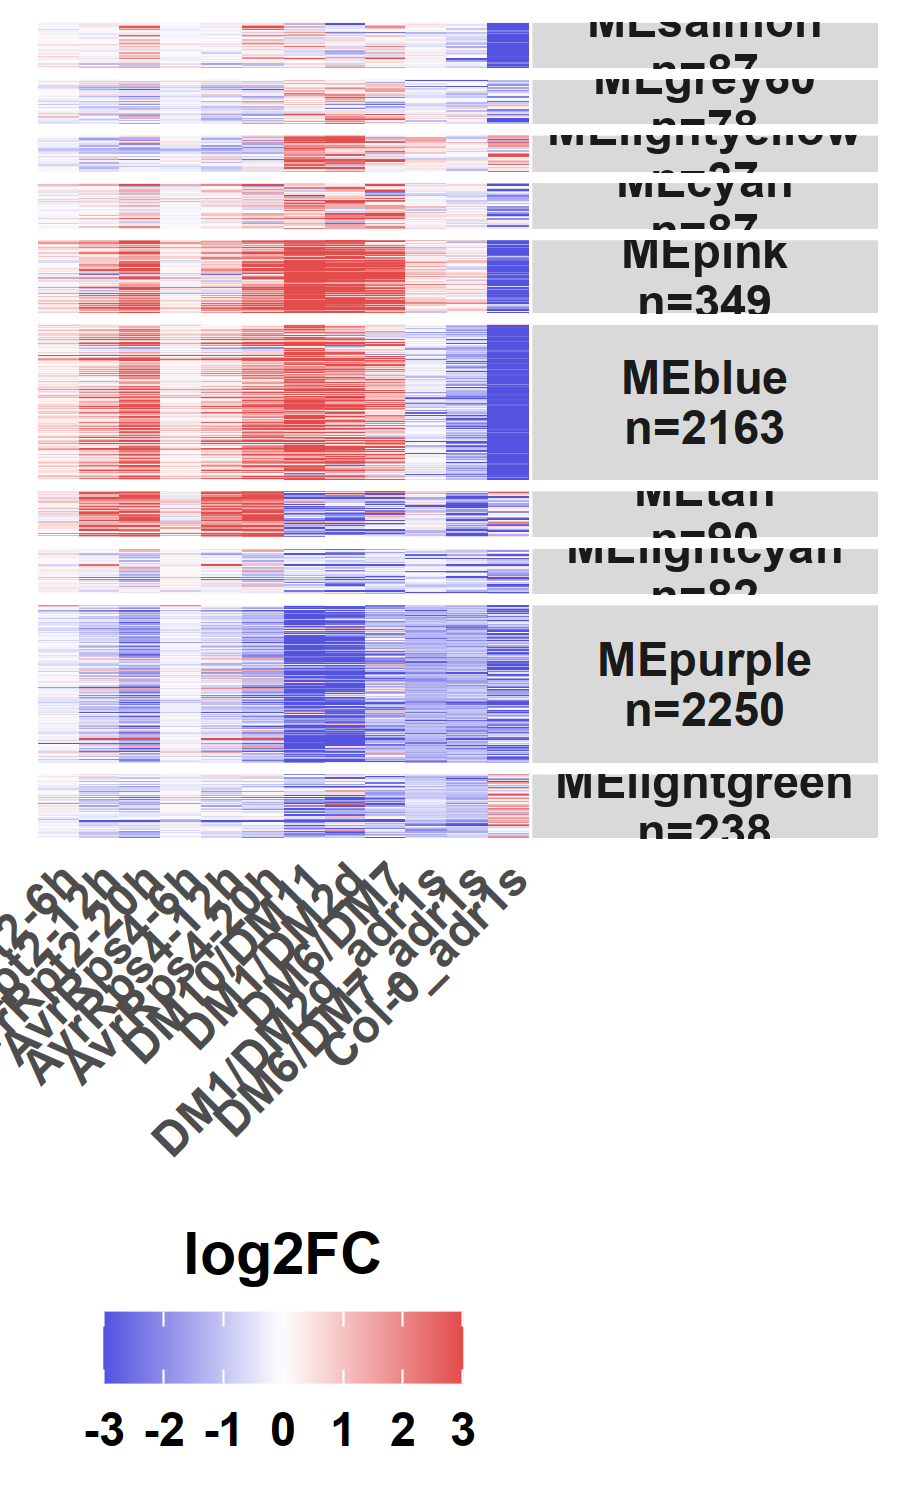

In [119]:
options(repr.plot.width= width_ , repr.plot.height= height_ , repr.plot.res = 300)

library(RColorBrewer)
plot <- Res_combined %>% ggplot(aes(x = source, y = AGI, fill = log2FC)) +
    geom_tile() +
    scale_fill_gradientn(
        colors = colorRampPalette(rev(c( '#e34c4b', 'white', '#5453e0' )))(30),
        limits = c(-3, 3),
        guide = guide_colorbar(title = "log2FC", title.position = "top", title.hjust = 0.5, direction = "horizontal"),
        oob = scales::oob_squish # out of limit values use max or min color
    )  +
    facet_grid(Module_n ~ ., scales = "free_y", space = "free_y") + 
    theme(
        text = element_text(face="bold", size=14,  family = 'Helvetica'),
        axis.text.y = element_blank(),
        axis.line  = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        strip.text.y = element_text(angle = 0),  # Make facet labels horizontal
        panel.spacing = unit(0.2, "lines"), ## spacing between facets
        legend.position = "bottom"
    ) 

module_list_sqrt <- lapply(module_list, sqrt) #some modules too few genes
module_list_sqrt_plus <- lapply(module_list_sqrt, function(x) x + 6)

plot1 <- plot + force_panelsizes(rows = module_list_sqrt_plus)
plot1
# plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.pdf'), height = 8, width = 8.3)
plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.pdf'), width = width_, height = height_ )


In [106]:
module_list

$MEsalmon
[1] 87

$MEgrey60
[1] 78

$MElightyellow
[1] 37

$MEcyan
[1] 87

$MEpink
[1] 349

$MEblue
[1] 2163

$MEtan
[1] 90

$MElightcyan
[1] 82

$MEpurple
[1] 2250

$MElightgreen
[1] 238

In [107]:
Res_combined %>% pull(source) %>% unique

[1] DM6/DM7        DM1/DM2d       DM10/DM11      AvrRpt2-6h     AvrRpt2-12h   
 [6] AvrRpt2-20h    AvrRps4-6h     AvrRps4-12h    AvrRps4-20h    DM1/DM2d_adr1s
[11] Col-0_adr1s    DM6/DM7_adr1s 
12 Levels: AvrRpt2-6h AvrRpt2-12h AvrRpt2-20h AvrRps4-6h ... Col-0_adr1s

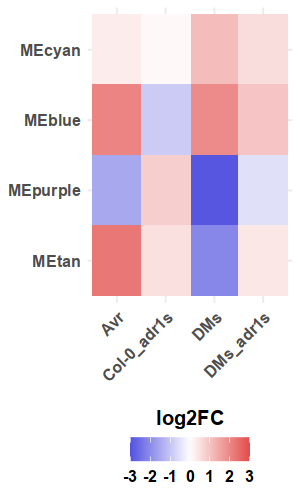

In [108]:
library(RColorBrewer)
library(ggplot2)
library(dplyr)
library(forcats)

# Update plot settings
width_ <- 3
height_ <- 5
options(repr.plot.width= width_, repr.plot.height= height_, repr.plot.res = 100)

# Data processing and ggplot
plot_tile <- Res_combined %>%
  mutate(module = factor(module, levels = c('MEcyan', 'MEmidnightblue', 'MEblue', 'MEpurple', 'MEdarkred', 'MEtan'))) %>%
    filter(str_detect(source, 'AvrRpt2-20h|DM1/DM2d|DM1/DM2d_adr1s|Col-0_adr1s')) %>%
    group_by(source, module) %>%
    summarize(mean_log2FC = mean(log2FC), .groups = 'drop') %>%
    ungroup() %>% filter(module %>% str_detect('MEcyan|MEmidnightblue|MEblue|MEdarkred|MEpurple|MEdarkred|MEtan')) %>%
    mutate( source = source %>% str_replace_all('AvrRpt2-20h', 'Avr') %>% str_replace_all('DM1/DM2d', 'DMs') ) %>%
    mutate(module = fct_rev(module)) %>%  # Reverses the order of module factor levels
    ggplot(aes(x = source, y = module, fill = mean_log2FC)) +
    geom_tile() +
    scale_fill_gradientn(
        colors = colorRampPalette(rev(c('#e34c4b', 'white', '#5453e0')))(30),
        limits = c(-3, 3),
        guide = guide_colorbar(title = "log2FC", title.position = "top", title.hjust = 0.5, direction = "horizontal"),
        oob = scales::oob_squish
    ) + theme_minimal()+
    theme(
        text = element_text(face="bold", size=14, family = 'Helvetica'),
        axis.line = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        strip.text.y = element_text(angle = 0),
        panel.spacing = unit(0.2, "lines"),
        legend.position = "bottom"
    )
plot_tile
plot_tile %>% ggsave(file = paste0(plots_path, 'tile', Sys.time(), '.pdf'), width = width_, height = height_ )

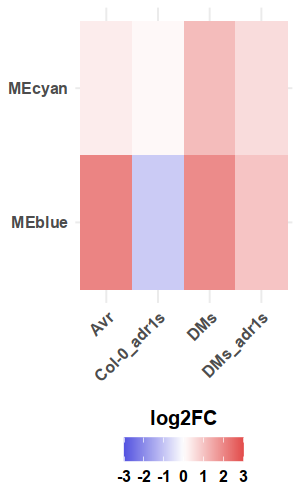

In [109]:
library(RColorBrewer)
library(ggplot2)
library(dplyr)
library(forcats)

# Update plot settings
width_ <- 3
height_ <- 5
options(repr.plot.width= width_, repr.plot.height= height_, repr.plot.res = 100)

# Data processing and ggplot
plot_tile <- Res_combined %>% 
    filter(str_detect(source, 'AvrRpt2-20h|DM1/DM2d|DM1/DM2d_adr1s|Col-0_adr1s')) %>%
    group_by(source, module) %>%
    summarize(mean_log2FC = mean(log2FC), .groups = 'drop') %>%
    ungroup() %>% filter(module %>% str_detect('MEcyan|MEmidnightblue|MEblue|MEdarkred|MEPurple|MEdark')) %>%
    mutate( source = source %>% str_replace_all('AvrRpt2-20h', 'Avr') %>% str_replace_all('DM1/DM2d', 'DMs') ) %>%
    mutate(module = fct_rev(module)) %>%  # Reverses the order of module factor levels
    ggplot(aes(x = source, y = module, fill = mean_log2FC)) +
    geom_tile() +
    scale_fill_gradientn(
        colors = colorRampPalette(rev(c('#e34c4b', 'white', '#5453e0')))(30),
        limits = c(-3, 3),
        guide = guide_colorbar(title = "log2FC", title.position = "top", title.hjust = 0.5, direction = "horizontal"),
        oob = scales::oob_squish
    ) + theme_minimal()+
    theme(
        text = element_text(face="bold", size=14, family = 'Helvetica'),
        axis.line = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        strip.text.y = element_text(angle = 0),
        panel.spacing = unit(0.2, "lines"),
        legend.position = "bottom"
    )
plot_tile
plot_tile %>% ggsave(file = paste0(plots_path, 'tile', Sys.time(), '.pdf'), width = width_, height = height_ )

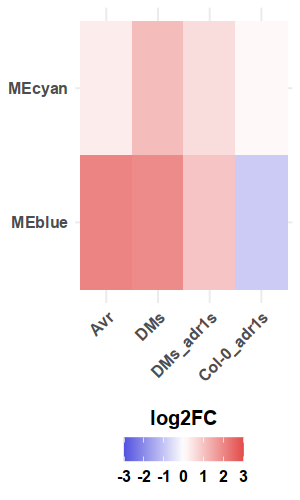

In [110]:
library(RColorBrewer)
library(ggplot2)
library(dplyr)
library(forcats)

# Update plot settings
width_ <- 3
height_ <- 5
options(repr.plot.width= width_, repr.plot.height= height_, repr.plot.res = 100)

# Data processing and ggplot
plot_tile <- Res_combined %>% 
    filter(str_detect(source, 'AvrRpt2-20h|DM1/DM2d|DM1/DM2d_adr1s|Col-0_adr1s')) %>%
    group_by(source, module) %>%
    summarize(mean_log2FC = mean(log2FC), .groups = 'drop') %>%
    ungroup() %>%
    filter(str_detect(module, 'MEcyan|MEmidnightblue|MEblue|MEdarkred|MEPurple|MEdark')) %>%
    mutate(source = str_replace_all(source, 'AvrRpt2-20h', 'Avr')) %>%
    mutate(source = str_replace_all(source, 'DM1/DM2d', 'DMs')) %>%
    mutate(module = fct_rev(module)) %>%  # Reverses the order of module factor levels
    mutate(source = fct_relevel(source, 'Avr', 'DMs', 'DMs_adr1s', 'Col-0_adr1s')) %>% # Reorder x-axis
    ggplot(aes(x = source, y = module, fill = mean_log2FC)) +
    geom_tile() +
    scale_fill_gradientn(
        colors = colorRampPalette(rev(c('#e34c4b', 'white', '#5453e0')))(30),
        limits = c(-3, 3),
        guide = guide_colorbar(title = "log2FC", title.position = "top", title.hjust = 0.5, direction = "horizontal"),
        oob = scales::oob_squish
    ) + 
    theme_minimal() +
    theme(
        text = element_text(face="bold", size=14, family = 'Helvetica'),
        axis.line = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        strip.text.y = element_text(angle = 0),
        panel.spacing = unit(0.2, "lines"),
        legend.position = "bottom"
    )

plot_tile

plot_tile %>% ggsave(file = paste0(plots_path, 'tile', Sys.time(), '.pdf'), width = width_, height = height_ )

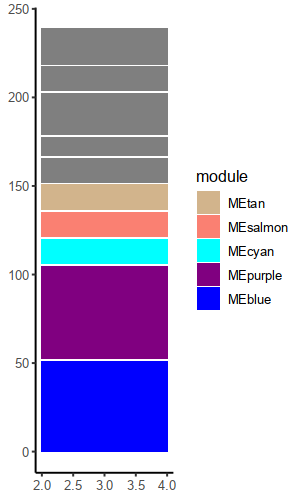

In [111]:
library(ggplot2)
library(dplyr)

# Create a data frame
df <- data.frame(
  module = names(module_list_sqrt_plus),
  height = unlist(module_list_sqrt_plus),
  color = unlist(module_colors)
)

# Reorder factor levels
levels_order <- c('MEmidnightblue', 'MEdarkgreen', 'MEtan', 'MEsalmon', 'MEgreenyellow', 'MEdarkred', 'MEcyan', 'MEdarkturquoise', 'MEpurple', 'MEblue')
df$module <- factor(df$module, levels = levels_order)

# Compute y positions with a gap of 0.2 between each tile
df <- df %>%
  arrange(desc(module)) %>%
  mutate(ymin = cumsum(height) - height,
         ymax = cumsum(height) - 1.4)  # subtract 0.2 from ymax to create a space

# Create the plot
tiles <- ggplot(df, aes(fill = module, ymin = ymin, ymax = ymax)) +
  geom_rect(aes(xmin = 2, xmax = 4)) +
  scale_fill_manual(values = module_colors) +
  theme_classic() 

tiles
tiles %>% ggsave(file = paste0(plots_path, 'tiles', Sys.time(), '.pdf'), width = width_, height = height_ )


In [112]:
df %>% select(module, color)

module   color  
MEblue        MEblue   #8B0000
MEpurple      MEpurple #800080
MEcyan        MEcyan   #FA8072
MEsalmon      MEsalmon #00009C
MEtan         MEtan    #00FFFF
MEgrey60      NA       #006400
MElightyellow NA       #D2B48C
MEpink        NA       #ADFF2F
MElightcyan   NA       #00CED1
MElightgreen  NA       #0000FF

# biomart

In [113]:
node_data_info <- node_data %>% mutate(module = paste0('ME', module )) %>% mutate(module = factor(module, levels = rownames(moduleTraitCor))) %>% left_join(map_id_name , by =c('gene' = 'gene_id'))

In [114]:
connectivity_table_info <- connectivity_table %>% arrange(desc(connectivity_rowSums_adj)) %>% 
    mutate(module = paste0('ME', module ))  %>% select(-gene_name) %>%
    left_join(map_id_name , by =c('gene' = 'gene_id'))

In [115]:
connectivity_table_info <- connectivity_table_info %>% left_join (
    Res_combined  %>% distinct() %>% pivot_wider(names_from = source, values_from = log2FC) %>% dplyr::select(-module,  -n, -Module_n),
    by = c('gene' = 'AGI'))

In [116]:
require(openxlsx)

wb <- createWorkbook()
for (i in connectivity_table_info %>% pull(module) %>% unique) {
#     print(i)
    addWorksheet(wb, i)
    writeData(wb, i, connectivity_table_info %>% filter(module == i))
    
}
saveWorkbook(wb, file = paste0(WGCNA_export_path, "/connectivity_info.xlsx"), overwrite = T)

In [117]:
connectivity_table_info %>% saveRDS(paste0(WGCNA_export_path, "/RDS/connectivity_info.rds"))

Warning message in gzfile(file, mode):
“cannot open compressed file './WGCNA_output_all_test/RDS/connectivity_info.rds', probable reason 'No such file or directory'”


ERROR: Error in gzfile(file, mode): cannot open the connection


In [ ]:
#get current working dir, 
getwd()


In [ ]:
connectivity_table_info %>% write.csv( paste0(WGCNA_export_path, "/connectivity_info.csv"), 
                                      row.names= F)

In [ ]:
connectivity_table_info %>% filter(gene == 'AT4G14400')

In [ ]:
connectivity_table_info %>% filter(gene == 'AT4G14390')

In [ ]:
library(biomaRt)
# library(Biostrings)
# library(BSgenome.Athaliana.TAIR.TAIR9)

In [ ]:
# Specify the genes of interest
genes_of_interest <- top_50_each_module$gene

# Use the BioMart database
plant_mart <- useMart(biomart = "plants_mart", host="https://plants.ensembl.org")
athaliana <- useDataset("athaliana_eg_gene", mart = plant_mart)

# Get the gene information
gene_info <- getBM(attributes=c('ensembl_gene_id', 'chromosome_name', 'strand', 'start_position', 'end_position', 'transcription_start_site'),
                   filters = 'ensembl_gene_id',
                   values = genes_of_interest,
                   mart = athaliana)

# Separate dataframe by strand
strand_positive <- gene_info %>% filter(strand == 1)
strand_negative <- gene_info %>% filter(strand == -1)

# For strand == 1, keep row with min transcription_start_site
strand_positive <- strand_positive %>% 
  group_by(ensembl_gene_id) %>% 
  filter(transcription_start_site == min(transcription_start_site))

# For strand == -1, keep row with max transcription_start_site
strand_negative <- strand_negative %>% 
  group_by(ensembl_gene_id) %>% 
  filter(transcription_start_site == max(transcription_start_site))

# Combine the dataframes
gene_info_filtered <- bind_rows(strand_positive, strand_negative) %>%
    filter(ensembl_gene_id %>% str_detect('AT\\dG'))

In [ ]:
# Initialize an empty list to store the sequences
sequences <- list()

# Loop over the filtered gene info dataframe
for (i in 1:nrow(gene_info_filtered)) {
  # Get the current gene's info
  current_gene <- gene_info_filtered[i, ]
  
  # Calculate the start and end positions
  if (current_gene$strand == 1) {
    start <- current_gene$transcription_start_site - 1799
    end <- current_gene$transcription_start_site + 200
  } else {
    start <- current_gene$transcription_start_site - 200
    end <- current_gene$transcription_start_site + 1799
  }
  
  # Extract the sequence
  sequence <- getSeq(BSgenome.Athaliana.TAIR.TAIR9, 
                     names = paste0("Chr", current_gene$chromosome_name),
                     start = start,
                     end = end)
  
  # If the gene is on the negative strand, reverse complement the sequence
  if (current_gene$strand == -1) {
    sequence <- reverseComplement(sequence)
  }
  
  # Add the sequence to the list, with the gene ID as the name
  sequences[[current_gene$ensembl_gene_id]] <- sequence
}

# Convert the list to a DNAStringSet
sequences_set <- DNAStringSet(unlist(sequences))

# Add names to the DNAStringSet
names(sequences_set) <- names(sequences)

# Write the sequences to a FASTA file
writeXStringSet(sequences_set, filepath = paste0(WGCNA_export_path, '/', "promtoters.fasta"))



In [ ]:
plantregmap_top50_each_module <- read.csv('./plantregmap/plantTFBS_fimo.txt', sep = '\t') %>% 
    dplyr::select(1, 3) %>% dplyr::rename('TF' = 'X.pattern.name', 'target' = 'sequence.name' ) 

In [ ]:
plantregmap_top50_each_module <- plantregmap_top50_each_module %>% semi_join(top_50_each_module, by = c('TF' = 'gene')) %>%
    semi_join(top_50_each_module, by = c('target' = 'gene')) %>% group_by(TF, target) %>% 
    summarise(TF_weight = n()) %>% mutate(source = 'TF') 

  #  write.csv(paste0(WGCNA_export_path, 'TF_top50_each_module', ".csv"), row.names = F, quote = F)

In [ ]:
plantregmap_top50_each_module %>% dplyr::rename('fromNode' = 'TF', 'toNode' = 'target') %>% 
    mutate(direction = 'directed', weight = NA)  %>% rbind(
    top_50_each_module_edge %>% mutate(source = 'correlation', TF_weight = NA) %>%
    dplyr::select(-toAltName, - fromAltName)
    ) %>% write.csv(paste0(WGCNA_export_path,'/', 'TF+WGCNA_top50_each_module', ".csv"), row.names = F, quote = F)

## NLRs LRRs in WGCNA modules

In [ ]:
NLRs_and_TIRs <- read.csv(file = "../gene_table_and_other_scripts/NLRs_and_TIR_only.csv") %>%
    dplyr::rename('GeneFamily' = 'Class')

In [ ]:
NLRs_and_TIRs_connectivity_table_info <- connectivity_table_info %>% semi_join(NLRs_and_TIRs, by = c('gene'= 'AGI')) %>%
    left_join(NLRs_and_TIRs, by = c('gene'= 'AGI'))

In [ ]:
require(openxlsx)

NLRs_and_TIRs_connectivity_table_info %>% write.csv(paste0(WGCNA_export_path, '/','NLRs_and_TIRs_connectivity_table_info', ".csv"), row.names = F, quote = F)

wb <- createWorkbook()
for (i in NLRs_and_TIRs_connectivity_table_info %>% pull(module) %>% unique) {
#     print(i)
    addWorksheet(wb, i)
    writeData(wb, i, NLRs_and_TIRs_connectivity_table_info %>% filter(module == i) %>% arrange(GeneFamily))
    
}
saveWorkbook(wb, file = paste0(WGCNA_export_path, "/NLRs_and_TIRs_connectivity_table_info.xlsx"), overwrite = T)

In [ ]:
Pathways_Ngou_2021 <- readxl::read_excel("../gene_table_and_other_scripts/Ngou_2021_Nature_figure2E_pathways_mod.xlsx")

In [ ]:
Pathways <- Pathways_Ngou_2021 %>% dplyr::select(Target, GeneFamily)
Pathways <- Pathways %>%as.data.frame  %>% dplyr::rename('AGI' = 'Target')
LRRs <- Pathways %>% filter(GeneFamily %>% str_detect('LRR'))

In [ ]:
connectivity_table_info %>% semi_join(LRRs, by = c('gene'= 'AGI')) %>%
    left_join(LRRs, by = c('gene'= 'AGI'))  %>% write.csv(paste0(WGCNA_export_path, '/','LRRs_connectivity_table_info', ".csv"), row.names = F, quote = F)